# Imports and data exploration

In [1]:
import io
import numpy as np
import random
import sys
from google.colab import drive
import io
import matplotlib.pyplot as plt
from collections import Counter
import re
import math
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback # To see the output text after each epoch of the training, and not just at the end
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Add, Dropout, GRU, concatenate
from tensorflow.keras.models import Model

seed = 42
keras.utils.set_random_seed(seed)

In [2]:
seed = 42
keras.utils.set_random_seed(seed)

In [3]:
drive.mount('/content/drive', force_remount=True)
root_dir = 'content/drive/My Drive/'
base_dir = root_dir

Mounted at /content/drive


In [4]:
# Correct file path
file_path = '/content/drive/My Drive/divina_commedia.txt'

# Open and read the file
with io.open(file_path, mode='r', encoding='utf-8') as f:
    text = f.read().lower()

print('Text length:', len(text))
print('\nFirst 1000 characters:\n')
print(text[:1000])


Text length: 558240

First 1000 characters:

inferno



inferno: canto i


nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai,
  diro` de l'altre cose ch'i' v'ho scorte.

io non so ben ridir com'i' v'intrai,
  tant'era pien di sonno a quel punto
  che la verace via abbandonai.

ma poi ch'i' fui al pie` d'un colle giunto,
  la` dove terminava quella valle
  che m'avea di paura il cor compunto,

guardai in alto, e vidi le sue spalle
  vestite gia` de' raggi del pianeta
  che mena dritto altrui per ogne calle.

allor fu la paura un poco queta
  che nel lago del cor m'era durata
  la notte ch'i' passai con tanta pieta.

e come quei che con lena affannata
  uscito fuor del pelago a la riva
  si volge a l'acqua perigliosa e guata,

cosi` l'animo 

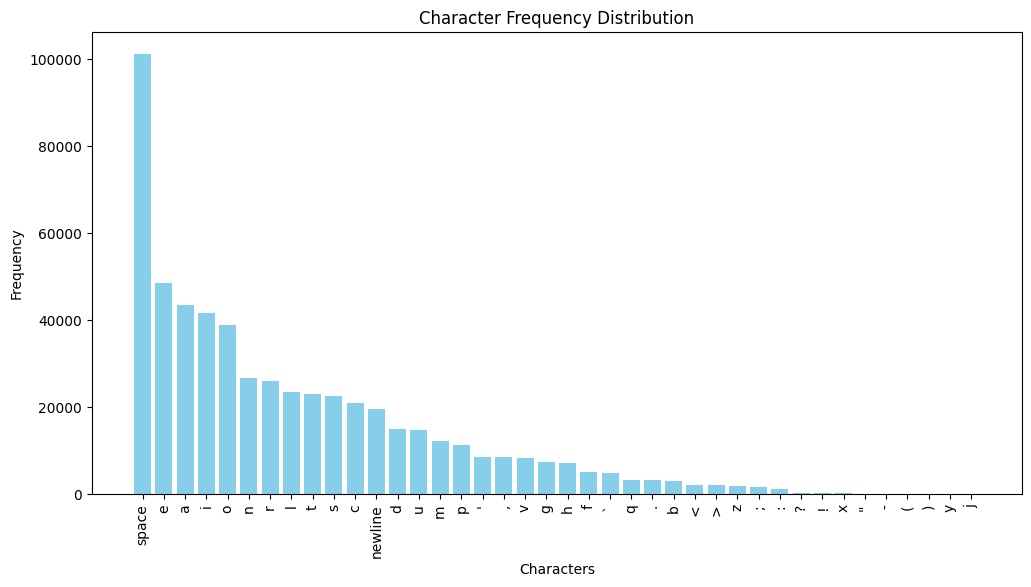

Top 10 most frequent characters:
'space' appears 101150 times (18.12%)
'e' appears 48639 times (8.71%)
'a' appears 43487 times (7.79%)
'i' appears 41658 times (7.46%)
'o' appears 38827 times (6.96%)
'n' appears 26664 times (4.78%)
'r' appears 26066 times (4.67%)
'l' appears 23508 times (4.21%)
't' appears 22907 times (4.10%)
's' appears 22663 times (4.06%)


In [5]:
# Count the frequency of each character in the text
char_counts = Counter(text)

# Add labels for special characters
char_labels = {" ": "space", "\n": "newline"}

# Update character keys with labels where applicable
labeled_char_counts = {char_labels.get(char, char): count for char, count in char_counts.items()}

# Recalculate total characters with labeled counts
total_characters = sum(labeled_char_counts.values())

# Separate the characters and their counts for plotting
characters = list(labeled_char_counts.keys())
frequencies = list(labeled_char_counts.values())

# Sort by frequency for better visualization
sorted_indices = sorted(range(len(frequencies)), key=lambda k: frequencies[k], reverse=True)
sorted_characters = [characters[i] for i in sorted_indices]
sorted_frequencies = [frequencies[i] for i in sorted_indices]

# Plot the character distribution
plt.figure(figsize=(12, 6))
plt.bar(sorted_characters, sorted_frequencies, color='skyblue')
plt.title('Character Frequency Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Display the top 10 most frequent characters
print("Top 10 most frequent characters:")
for char, freq in zip(sorted_characters[:10], sorted_frequencies[:10]):
    percentage = (freq / total_characters) * 100
    print(f"'{char}' appears {freq} times ({percentage:.2f}%)")


# First model
This is the starter model we created during the laboratory.

Some code has been rivisited to better show results or to prepare functions that will be useful later.

A simple data split has been added, to create the training, validation and test set.

## Data preparation

Data preparation for the first model

In [6]:
# Extract all unique characters from the text, sort them, and store them in a list
chars = sorted(list(set(text)))  # Extracts all unique characters in the text, converts the set to a list and sorts them alphabetically
print('Total unique characters:', len(chars))

# Maps
# Each unique character is assigned a unique numerical index
char_indices = dict((c, i) for i, c in enumerate(chars))  # Translates the characters into indices
# Each index is mapped back to its corresponding character
indices_char = dict((i, c) for i, c in enumerate(chars))  # The opposite map

# Print character-to-index mapping in a readable way
print("Character to Index Mapping:")
for char, idx in char_indices.items():
    print(f"'{char}': {idx}")

# Print index-to-character mapping in a readable way
print("\nIndex to Character Mapping:")
for idx, char in indices_char.items():
    print(f"{idx}: '{char}'")


Total unique characters: 40
Character to Index Mapping:
'
': 0
' ': 1
'!': 2
'"': 3
''': 4
'(': 5
')': 6
',': 7
'-': 8
'.': 9
':': 10
';': 11
'<': 12
'>': 13
'?': 14
'`': 15
'a': 16
'b': 17
'c': 18
'd': 19
'e': 20
'f': 21
'g': 22
'h': 23
'i': 24
'j': 25
'l': 26
'm': 27
'n': 28
'o': 29
'p': 30
'q': 31
'r': 32
's': 33
't': 34
'u': 35
'v': 36
'x': 37
'y': 38
'z': 39

Index to Character Mapping:
0: '
'
1: ' '
2: '!'
3: '"'
4: '''
5: '('
6: ')'
7: ','
8: '-'
9: '.'
10: ':'
11: ';'
12: '<'
13: '>'
14: '?'
15: '`'
16: 'a'
17: 'b'
18: 'c'
19: 'd'
20: 'e'
21: 'f'
22: 'g'
23: 'h'
24: 'i'
25: 'j'
26: 'l'
27: 'm'
28: 'n'
29: 'o'
30: 'p'
31: 'q'
32: 'r'
33: 's'
34: 't'
35: 'u'
36: 'v'
37: 'x'
38: 'y'
39: 'z'


The following function generates the sequences of length sentenceLength from the text, with a defined step size (how much to move the starting point of the next sentence).

In [7]:
def generate_sequences(text, sentence_length, step_size):
    sentences = [] # List to store the sequences (chunks of text of length sentenceLength)
    next_chars = [] # List to store the character that follows each sequence
    for i in range(0, len(text) - sentence_length, step_size):
        sentences.append(text[i: i + sentence_length])  # Extract a chunk of text
        next_chars.append(text[i + sentence_length])    # Append the next character

    return sentences, next_chars

sentence_length = 30
sentences, next_chars = generate_sequences(text, sentence_length, 3)

print('Number of sequences:', len(sentences))
print('Example sequence:', sentences[11])
print('Next character:', next_chars[11])

Number of sequences: 186070
Example sequence:  mezzo del cammin di nostra vi
Next character: t


The following code one-hot encodes each character of each sentence and the next characters, using the char_indices dictionary to put 'True' in the right position of each encoding array (that represents a character).

In [8]:
def one_hot_encode_sequences(sentences, next_chars, char_indices, sentence_length):
    # First dimension: Total number of sequences
    # Second dimension: Sequence length, which is the fixed number of characters per sequence
    # Third dimension: Number of unique characters (len(chars)) used for one-hot encoding
    # Each entry will be a boolean indicating the presence of a character at a specific position in the sequence
    x = np.zeros((len(sentences), sentence_length, len(char_indices)), dtype=bool)

    # First dimension: Total number of sequences
    # Second dimension: Number of unique characters (len(chars)) used for one-hot encoding
    # Each entry will be a boolean indicating the target character for the sequence
    y = np.zeros((len(sentences), len(char_indices)), dtype=bool)

    for i, sentence in enumerate(sentences):  # Loop through each sequence and its index
        for t, char in enumerate(sentence):  # Loop through each character in the current sequence
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1

    return x, y

x, y = one_hot_encode_sequences(sentences, next_chars, char_indices, sentence_length)
print('x shape: ', x.shape)  # number of sequences, sequence length, number of unique characters
print('y shape: ', y.shape)  # number of sequences, number of unique characters
print('\nexample of how a single character is encoded: \n', x[1][1])  # Example of how a single character of the sequence is encoded

x shape:  (186070, 30, 40)
y shape:  (186070, 40)

example of how a single character is encoded: 
 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False]


This is a simple 60-20-20 data split, that splits the data sequentially, and has overlaps between sets. I will improve on it in later sections.

In [9]:
# Split between training , validation and test sets
train_ratio = 0.6
val_ratio = 0.2

# Determine the number of samples
num_samples = x.shape[0]
train_size = int(num_samples * train_ratio)
val_size = int(num_samples * val_ratio)

# Perform the splits
x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size]
x_test, y_test = x[train_size + val_size:], y[train_size + val_size:]

# Print the shapes of the resulting splits
print('Train set x shape:', x_train.shape, 'y shape:', y_train.shape)
print('Validation set x shape:', x_val.shape, 'y shape:', y_val.shape)
print('Test set x shape:', x_test.shape, 'y shape:', y_test.shape)

Train set x shape: (111642, 30, 40) y shape: (111642, 40)
Validation set x shape: (37214, 30, 40) y shape: (37214, 40)
Test set x shape: (37214, 30, 40) y shape: (37214, 40)


In [10]:
def testAfterEpoch(epoch, _):
  print()
  print()
  print('*********** Epoch %d ***********' % (epoch+1)) # Printing the epoch

  # Randomly select a starting index for generating test data
  # and ensures the starting point is valid, leaves enough room for maxlen characters
  start_index = random.randint(0, len(text)-sentence_length-1)

  generated = ''
  sentence = text[start_index : start_index + sentence_length] # Extracts the sentence to test with
  generated = generated + sentence

  print('****** Starting sentence: ******')
  print(sentence)
  print('********************************')
  sys.stdout.write(generated)

  # Generation of the characters following the sentence
  for i in range(200):
    x_pred = np.zeros((1, sentence_length, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1

    preds = model.predict(x_pred, verbose = 0)[0]
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char # Update the sentence by discarding the first character and appening the prediction

    sys.stdout.write(next_char)
    sys.stdout.flush()
  print()


In [11]:
print_callback = LambdaCallback(on_epoch_end = testAfterEpoch)

## First model's architecture and results

I have added the accuracy metric and the print of the history.

In [12]:
# Minimum model that we can have
# A LSTM followed by a dense layer that maps into the one-hot encoding representation
# We could modify the architecture to get better performance, you could have some dense layers
# between the input and the LSTM, or more dense layers after
model = Sequential()
model.add(LSTM(128, input_shape=(sentence_length, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(x_train, y_train,
          batch_size = 2048,
          epochs = 20,
          validation_data=(x_val, y_val),
          callbacks = [print_callback])

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1651 - loss: 3.1016

*********** Epoch 1 ***********
****** Starting sentence: ******
nforta
  le fredde membra che 
********************************
nforta
  le fredde membra che se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.1658 - loss: 3.0972 - val_accuracy: 0.3063 - val_loss: 2.3656
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3005 - loss: 2.3395

*********** Epoch 2 ***********
****** Starting sentence: ******
aro,
  s'anima e` qui tra voi 
********************************
aro,
  s'anima e` qui tra voi a la si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si si 

In [14]:
def plot_training_metrics(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot Training vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training vs Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plot
    plt.show()

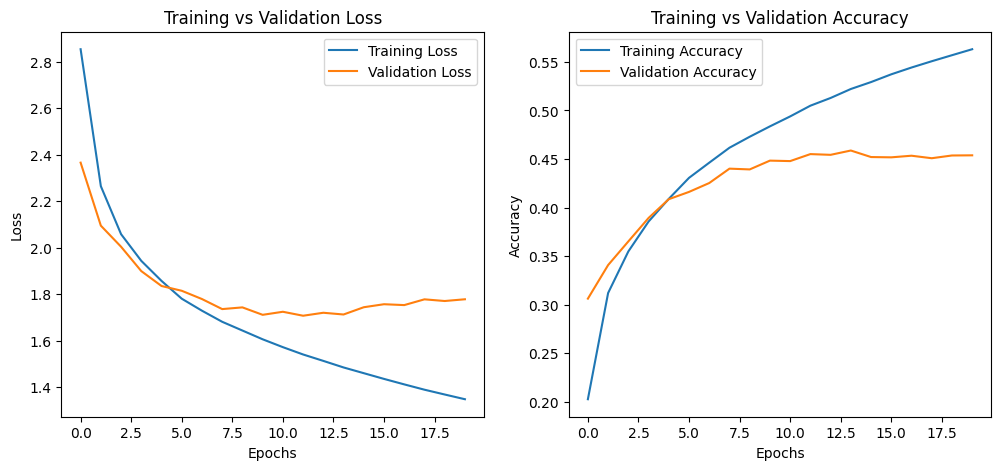

In [15]:
plot_training_metrics(history)

# Second model: proper dataset division

I have built the training, validation and test set, sampling from the text in a proper way, avoiding adding any bias (there was bias in the previous model, since the sequences were sequentially divided after they were encoded, so some sub-sequences were shared between different sets).

## Data processing

In [16]:
# Divide the text into sub-sections
partitioned_text = re.split(r'(?<=\n\n\n\n\n)', text)

This method splits the text every time it finds 5 '\n' in a row. This is a very simple way to create 3 subsets, dividing 'Inferno', 'Purgatorio' and 'Paradiso'.

This is very useful and needed, because the 'Divina Commedia' is written in a different way in each section, so just dividing the text sequentially with a 60-20-20 division would leave sections for the validation and test set that could be too different from the training set to predict well.

In [17]:
partition_lengths = [len(part) for part in partitioned_text]

# Display the number of characters in each partition
for i, length in enumerate(partition_lengths):
    print(f"Partition {i + 1}: {length} characters")

Partition 1: 186808 characters
Partition 2: 187399 characters
Partition 3: 184033 characters


In [18]:
print(partitioned_text[0][:200]) # Print the first 200 characters of the first partition (inferno)

inferno



inferno: canto i


nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia 


In [19]:
print(partitioned_text[1][:200]) # Print the first 200 characters of the second partition (purgatorio)

la divina commedia
di dante alighieri
(e-text courtesy progetto manuzio)

purgatorio



purgatorio: canto i


per correr miglior acque alza le vele
  omai la navicella del mio ingegno,
  che lascia di


In [20]:
print(partitioned_text[2][:200]) # Print the first 200 characters of the third partition (paradiso)

la divina commedia
di dante alighieri
(e-text courtesy progetto manuzio)

paradiso



paradiso: canto i


la gloria di colui che tutto move
  per l'universo penetra, e risplende
  in una parte piu` e 


Se seen in the prints above, there seems to be an 'append' mistake in the original text, that includes some extra senteneces from the ebooks that were put together. I have removed those extra lines, to keep the data cleaner.

In [21]:
# Remove the first 4 lines from partition 2
partitioned_text[1] = "\n".join(partitioned_text[1].splitlines()[4:])

# Remove the first 4 lines from partition 3
partitioned_text[2] = "\n".join(partitioned_text[2].splitlines()[4:])

In [22]:
print(partitioned_text[1][:200]) # Check that the result is correct

purgatorio



purgatorio: canto i


per correr miglior acque alza le vele
  omai la navicella del mio ingegno,
  che lascia dietro a se' mar si` crudele;

e cantero` di quel secondo regno
  dove l'uma


In [23]:
print(partitioned_text[2][:200]) # Check that the result is correct

paradiso



paradiso: canto i


la gloria di colui che tutto move
  per l'universo penetra, e risplende
  in una parte piu` e meno altrove.

nel ciel che piu` de la sua luce prende
  fu' io, e vidi co


The following function takes as input the single partition (so either inferno, purgatorio or paradiso), and the proportion to use to divide into sub-sets. It returns the train_set, val_set and test_set.

In [24]:
def split_partition(partition, train_size=0.6, val_size=0.2, test_size=0.2):
    # Calculate the size of the split in terms of characters
    total_length = len(partition)
    train_end = math.floor(total_length * train_size)
    val_end = train_end + math.floor(total_length * val_size)

    # Split into train, validation, and test sets
    train_set = partition[:train_end]
    val_set = partition[train_end:val_end]
    test_set = partition[val_end:]

    return train_set, val_set, test_set

The prepare_data function takes as input the whole partitioned text (so after it was divided in 3) and the length that each sequence should be. The function creates the training, validation and test sets (x and y) also using the previously defined functions 'split_partition', 'generate_sequences' and 'one_hot_encode_sequences'.

Basically, it takes the 3 partitions of the text, and divides each one with the proportions 60-20-20, and then puts the corrisponding subsets together, to create the final split between train, val and test.

In [25]:
def prepare_data(partitioned_text, sentence_length, partition_function=split_partition, stride=3):
    # Initialize empty lists for the sequences
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    # Loop through each partition and split it, then append the results as text
    for partition in partitioned_text:
        # Split the current partition into train, validation, and test sets
        train_partition, val_partition, test_partition = partition_function(partition)

        # Generate sequences and one-hot encode for training data
        sentences, next_chars = generate_sequences(train_partition, sentence_length, stride)
        x, y = one_hot_encode_sequences(sentences, next_chars, char_indices, sentence_length)

        x_train.append(x)  # Add x to train
        y_train.append(y)  # Add y to train

        # Generate sequences and one-hot encode for validation data
        sentences, next_chars = generate_sequences(val_partition, sentence_length, stride)
        x, y = one_hot_encode_sequences(sentences, next_chars, char_indices, sentence_length)
        x_val.append(x)  # Add x to validation
        y_val.append(y)  # Add y to validation

        # Generate sequences and one-hot encode for test data
        sentences, next_chars = generate_sequences(test_partition, sentence_length, stride)
        x, y = one_hot_encode_sequences(sentences, next_chars, char_indices, sentence_length)
        x_test.append(x)  # Add x to test
        y_test.append(y)  # Add y to test

    # Convert lists to numpy arrays at the end to concatenate
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    x_val = np.concatenate(x_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    x_test = np.concatenate(x_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    # Return the final datasets
    return x_train, y_train, x_val, y_val, x_test, y_test

sentence_length = 30
x_train_2, y_train_2, x_val_2, y_val_2, x_test_2, y_test_2 = prepare_data(partitioned_text, sentence_length)

# Print the shapes of the final datasets to verify
print(f"Training data shape: {x_train_2.shape}, {y_train_2.shape}")
print(f"Validation data shape: {x_val_2.shape}, {y_val_2.shape}")
print(f"Test data shape: {x_test_2.shape}, {y_test_2.shape}")

Training data shape: (111589, 30, 40), (111589, 40)
Validation data shape: (37176, 30, 40), (37176, 40)
Test data shape: (37179, 30, 40), (37179, 40)


## Second model's architecture and results

I kept the model the same, for now.

In [26]:
keras.utils.set_random_seed(seed)

model2 = Sequential()
model2.add(LSTM(128, input_shape=(sentence_length, len(chars))))
model2.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

I have only added the "shuffle" option, to shuffle the training samples, so that they're not picked sequentially while training. Using them sequentially would mean first training with the subset of 'inferno', then the subset of 'purgatorio'... which would result in a worse generalization capacity.

I also removed the callback to speed up the training phase, since it's not really needed to check that out again, with the same architecture as before.

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history2 = model2.fit(x_train_2, y_train_2,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_2, y_val_2),
                      shuffle=True, # Shuffles the training samples
                      callbacks=[early_stopping])

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1380 - loss: 3.3022 - val_accuracy: 0.1814 - val_loss: 2.8408
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2189 - loss: 2.6917 - val_accuracy: 0.2569 - val_loss: 2.4736
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2860 - loss: 2.3774 - val_accuracy: 0.3038 - val_loss: 2.2853
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3167 - loss: 2.2226 - val_accuracy: 0.3383 - val_loss: 2.1327
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3350 - loss: 2.1249 - val_accuracy: 0.3465 - val_loss: 2.0692
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3558 - loss: 2.0414 - val_accuracy: 0.3739 - val_loss: 1.9820
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3735 - loss: 1.9711 - val_accuracy: 0.3834 - val_loss: 1.9393
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3888 - loss: 1.9163 - val_accuracy: 0.3951 - v

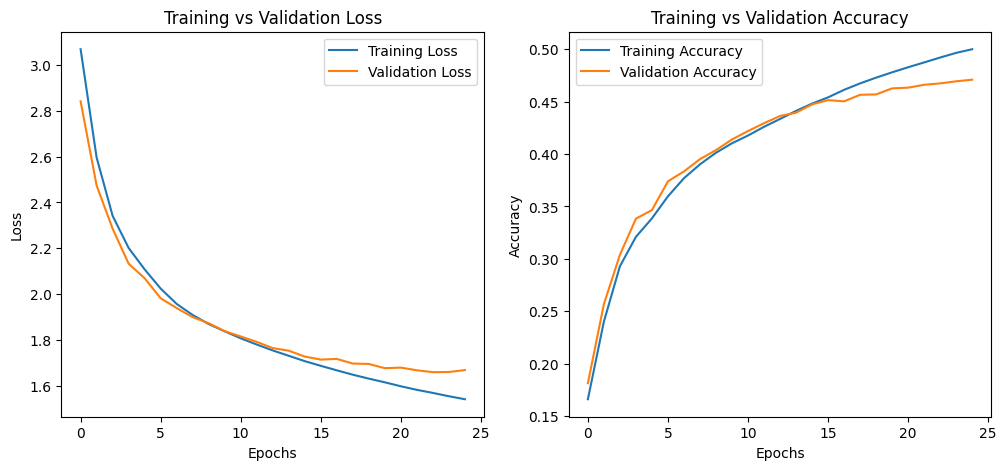

In [28]:
plot_training_metrics(history2)

There's a noticeable overfitting, but I will work on the model's architecture later.

In [29]:
y_pred = model2.predict(x_test_2) # Get the predictions

# Format class names for readability
class_names = [
    repr(indices_char[i]) for i in range(len(indices_char))
]  # Use repr() to show characters like ' ' and '\n'

# Convert predictions and true labels to class indices if necessary
y_pred_classes = y_pred.argmax(axis=-1)  # Convert probabilities to class indices
y_true = y_test_2.argmax(axis=-1)          # Convert one-hot encoded labels to class indices

# Print the classification report with formatted class names
print(classification_report(
    y_true,
    y_pred_classes,
    labels=list(indices_char.keys()),
    target_names=class_names,
    zero_division=0  # Suppresses warnings and assigns 0 for undefined metrics
))

1162/1162 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

        '\n'       0.67      0.77      0.72      1319
         ' '       0.71      0.90      0.79      6596
         '!'       0.00      0.00      0.00        12
         '"'       0.00      0.00      0.00         7
         "'"       0.47      0.08      0.14       557
         '('       0.00      0.00      0.00         0
         ')'       0.00      0.00      0.00         0
         ','       0.29      0.08      0.12       568
         '-'       0.00      0.00      0.00         2
         '.'       0.23      0.42      0.30       204
         ':'       0.28      0.23      0.25        74
         ';'       0.00      0.00      0.00        99
         '<'       0.81      0.77      0.79       130
         '>'       0.94      0.48      0.64       124
         '?'       0.00      0.00      0.00        19
         '`'       0.60      0.54      0.57       306
         'a'       0.35      0.48     

From these results, it's clear that the characters with the best accuracy in predictions are the space and '\n'.

In the case of the space it could be argued that the accuracy is so high because of how frequent it is. I think this is a fair assessment, because the precision (based on the positive prediction) is lower than the recall (based on the actual true values).

This can be said for most of the other characters that have the highest frequency, which is understandable.

However, the model has clearly learned some patterns, like when to go to a new line, or for instance how to use the '<' and '>' characters, which have patterns that are probably easier to predict than any other alphabetical character.

Lastly, it can be clearly seen how the classes with very few instances are not predicted at all.

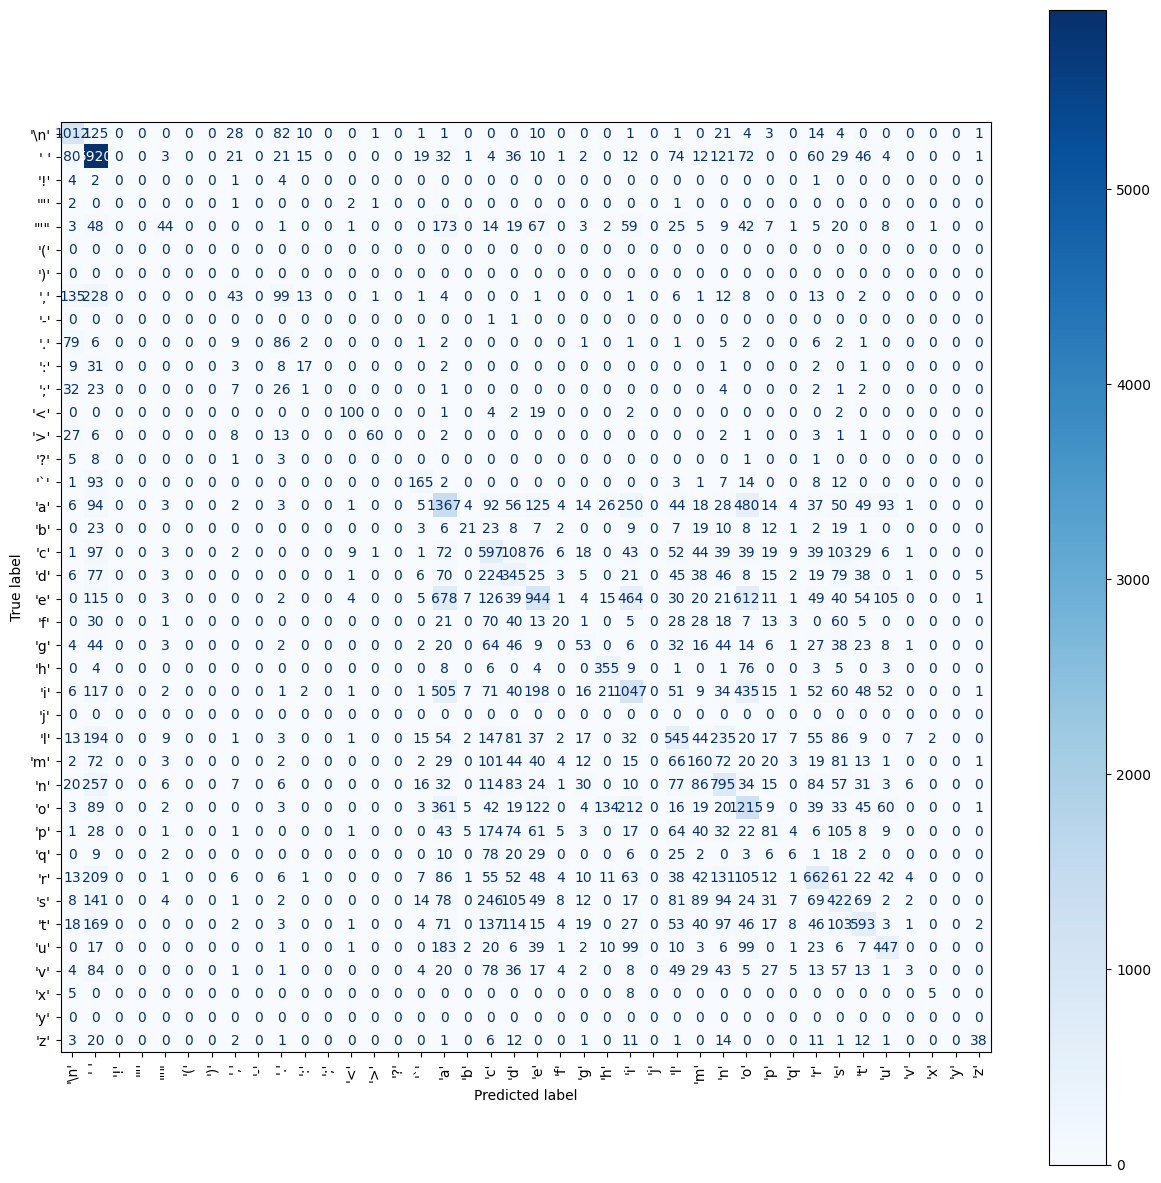

In [30]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=list(indices_char.keys()))

# Format class names for readability (e.g., showing ' ' and '\n')
formatted_class_names = [repr(indices_char[i]) for i in range(len(indices_char))]

# Create a larger plot
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed (width, height)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=formatted_class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=plt.gca())  # Use the current axis

# Show the plot
plt.show()


In the confusion matrix, it's interesting to see the square of predictions around the alphabetical characters (apart from a few like 'j', 'v', 'x').

This is consistent with what I have already wrote, the classes that are most predicted are the classes that are most frequent in the dataset.

The confusion matrix adds some interesing informations though, like how that 'square' around the alphabetical characters indicates that the letters are 'confused' witch each other, which is understandable, but the model isn't just making random predictions or predictions that are solely based on the frequency of the dataset, because if that was the case, the model would 'confuse' any character with every other.

The space character is also not predicted too well, and confused a lot with most of the other characters.

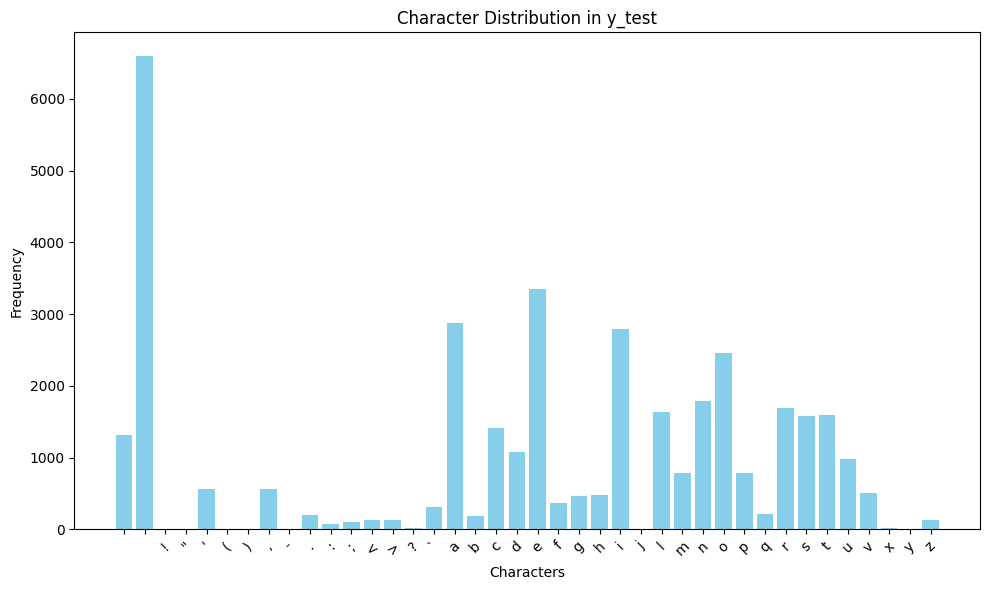

In [31]:
# Convert one-hot encoded labels to class indices
y_true_classes = y_test_2.argmax(axis=-1)

# Count the frequency of each class index in y_true_classes
class_counts = Counter(y_true_classes)

# Map indices back to character names
class_distribution = {indices_char[i]: class_counts[i] for i in class_counts}

# Ensure the order of characters is the same as in the confusion matrix (from indices_char)
ordered_characters = [indices_char[i] for i in range(len(indices_char))]
ordered_counts = [class_distribution.get(char, 0) for char in ordered_characters]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(ordered_characters, ordered_counts, color='skyblue')

# Rotate x-axis labels for readability (if needed)
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Character Distribution in y_test')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()


I printed the distribution of y_test to have a reference for all the consideration I have just made.

# Third model: even better dataset division

This is a better division (in my opinion). I have decided to implement it after discussing the matter with my high school literature teacher and a friend of mine that studies classic literature, because the language used changes not only between 'cantiche' (inferno uses a 'lower' everyday language, in paradiso the language has the highest 'elevation', it's lofty and refined, in purgatorio it's a mix of the two) but also between 'canti' (33 for each 'cantica', 34 for 'inferno'), for example depending on the characters that the protagonist meets (for example, the language used can be more simple, more sofisticated, more happy or more dark).

For this reason, I have decided to split the 3 'cantiche' in each 'canto', and then split each canto into the 3 sets (train, val, test), concatenating them together after. This helps balancing the way that the text is written more, although it's not perfectly balanced since the data is still split sequentially in each 'canto', but this is necessary to avoid overlapping sentences between different sets.

Extra interesting information: there are some terms that have been invented by Dante, so they don't appear in other books. There are also differnet words that have the same meaning, but they have a different elevation (e.g. 'vecchio' in purgatorio, 'veglio' in purgatorio and 'sene' in paradiso), some term are also only used once. This type of book isn't really a good dataset to use for prediction, because it's a 'commedia', so it's purposefully made to not be predictable

## Data processing

In [32]:
partitioned_text_canti_inferno = re.split(r'(?<=\n\n\n\n)', partitioned_text[0])

This splits the 'inferno' subset into the 'canti' (they should be 34 for inferno, 33 for the other two)

In [33]:
len(partitioned_text_canti_inferno)

37

In [34]:
partitioned_text_canti_inferno[0]

'inferno\n\n\n\n'

In [35]:
partitioned_text_canti_inferno[1]

"inferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, ch'ancor fuggiv

Some refinement is needed, to avoid the smaller divisions, for example the title is divided into its own partition, and at the end of the 'canto' there are a few more '\n'.

In [36]:
# Combine adjacent segments shorter than 100
i = 0
while i < len(partitioned_text_canti_inferno) - 1:
    if len(partitioned_text_canti_inferno[i]) < 100:
        # Combine the current item with the next one
        partitioned_text_canti_inferno[i] += partitioned_text_canti_inferno[i + 1]
        # Remove the next item from the list
        partitioned_text_canti_inferno.pop(i + 1)
    else:
        i += 1

In [37]:
partitioned_text_canti_inferno[0]

"inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, 

In [38]:
partitioned_text_canti_inferno[len(partitioned_text_canti_inferno)-2]

"inferno: canto xxxiv\n\n\n<<vexilla regis prodeunt inferni\n  verso di noi; pero` dinanzi mira>>,\n  disse 'l maestro mio <<se tu 'l discerni>>.\n\ncome quando una grossa nebbia spira,\n  o quando l'emisperio nostro annotta,\n  par di lungi un molin che 'l vento gira,\n\nveder mi parve un tal dificio allotta;\n  poi per lo vento mi ristrinsi retro\n  al duca mio; che' non li` era altra grotta.\n\ngia` era, e con paura il metto in metro,\n  la` dove l'ombre tutte eran coperte,\n  e trasparien come festuca in vetro.\n\naltre sono a giacere; altre stanno erte,\n  quella col capo e quella con le piante;\n  altra, com'arco, il volto a' pie` rinverte.\n\nquando noi fummo fatti tanto avante,\n  ch'al mio maestro piacque di mostrarmi\n  la creatura ch'ebbe il bel sembiante,\n\nd'innanzi mi si tolse e fe' restarmi,\n  <<ecco dite>>, dicendo, <<ed ecco il loco\n  ove convien che di fortezza t'armi>>.\n\ncom'io divenni allor gelato e fioco,\n  nol dimandar, lettor, ch'i' non lo scrivo,\n  pero` 

In [39]:
partitioned_text_canti_inferno[len(partitioned_text_canti_inferno)-1]

'\n'

In [40]:
# Handle the last segment
if len(partitioned_text_canti_inferno[-1]) < 100:
    partitioned_text_canti_inferno[-2] += partitioned_text_canti_inferno[-1]
    partitioned_text_canti_inferno.pop(-1)

In [41]:
partitioned_text_canti_inferno[len(partitioned_text_canti_inferno)-1]

"inferno: canto xxxiv\n\n\n<<vexilla regis prodeunt inferni\n  verso di noi; pero` dinanzi mira>>,\n  disse 'l maestro mio <<se tu 'l discerni>>.\n\ncome quando una grossa nebbia spira,\n  o quando l'emisperio nostro annotta,\n  par di lungi un molin che 'l vento gira,\n\nveder mi parve un tal dificio allotta;\n  poi per lo vento mi ristrinsi retro\n  al duca mio; che' non li` era altra grotta.\n\ngia` era, e con paura il metto in metro,\n  la` dove l'ombre tutte eran coperte,\n  e trasparien come festuca in vetro.\n\naltre sono a giacere; altre stanno erte,\n  quella col capo e quella con le piante;\n  altra, com'arco, il volto a' pie` rinverte.\n\nquando noi fummo fatti tanto avante,\n  ch'al mio maestro piacque di mostrarmi\n  la creatura ch'ebbe il bel sembiante,\n\nd'innanzi mi si tolse e fe' restarmi,\n  <<ecco dite>>, dicendo, <<ed ecco il loco\n  ove convien che di fortezza t'armi>>.\n\ncom'io divenni allor gelato e fioco,\n  nol dimandar, lettor, ch'i' non lo scrivo,\n  pero` 

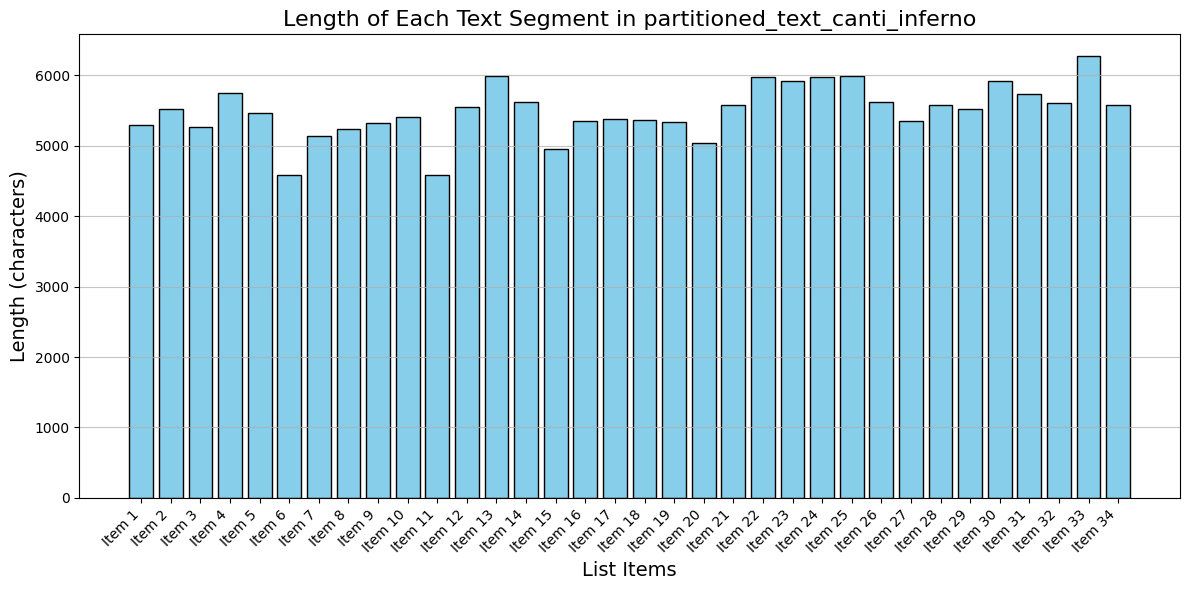

In [42]:
# Calculate the lengths of the items
lengths = [len(item) for item in partitioned_text_canti_inferno]

# Create x-axis labels
x_labels = [f"Item {i+1}" for i in range(len(partitioned_text_canti_inferno))]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x_labels, lengths, color='skyblue', edgecolor='black')
plt.title("Length of Each Text Segment in partitioned_text_canti_inferno", fontsize=16)
plt.xlabel("List Items", fontsize=14)
plt.ylabel("Length (characters)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

This is to check that the split went accoring to the plan, and to see that there are enough characters in each 'canto' to make splitting each one train, val and test a viable option.

The same is then applied to 'purgatorio' and 'paradiso'

In [43]:
# Find and print the minimum length
min_length = min(lengths)
print(f"The minimum length of the items is: {min_length}")

The minimum length of the items is: 4585


In [44]:
partitioned_text_canti_purgatorio = re.split(r'(?<=\n\n\n\n)', partitioned_text[1])
partitioned_text_canti_paradiso = re.split(r'(?<=\n\n\n\n)', partitioned_text[2])

In [45]:
i = 0
while i < len(partitioned_text_canti_purgatorio) - 1:
    if len(partitioned_text_canti_purgatorio[i]) < 100:
        partitioned_text_canti_purgatorio[i] += partitioned_text_canti_purgatorio[i + 1]
        partitioned_text_canti_purgatorio.pop(i + 1)
    else:
        i += 1

i = 0
while i < len(partitioned_text_canti_paradiso) - 1:
    if len(partitioned_text_canti_paradiso[i]) < 100:
        partitioned_text_canti_paradiso[i] += partitioned_text_canti_paradiso[i + 1]
        partitioned_text_canti_paradiso.pop(i + 1)
    else:
        i += 1

In [46]:
if len(partitioned_text_canti_purgatorio[-1]) < 100:
    partitioned_text_canti_purgatorio[-2] += partitioned_text_canti_purgatorio[-1]
    partitioned_text_canti_purgatorio.pop(-1)

if len(partitioned_text_canti_paradiso[-1]) < 100:
    partitioned_text_canti_paradiso[-2] += partitioned_text_canti_paradiso[-1]
    partitioned_text_canti_paradiso.pop(-1)

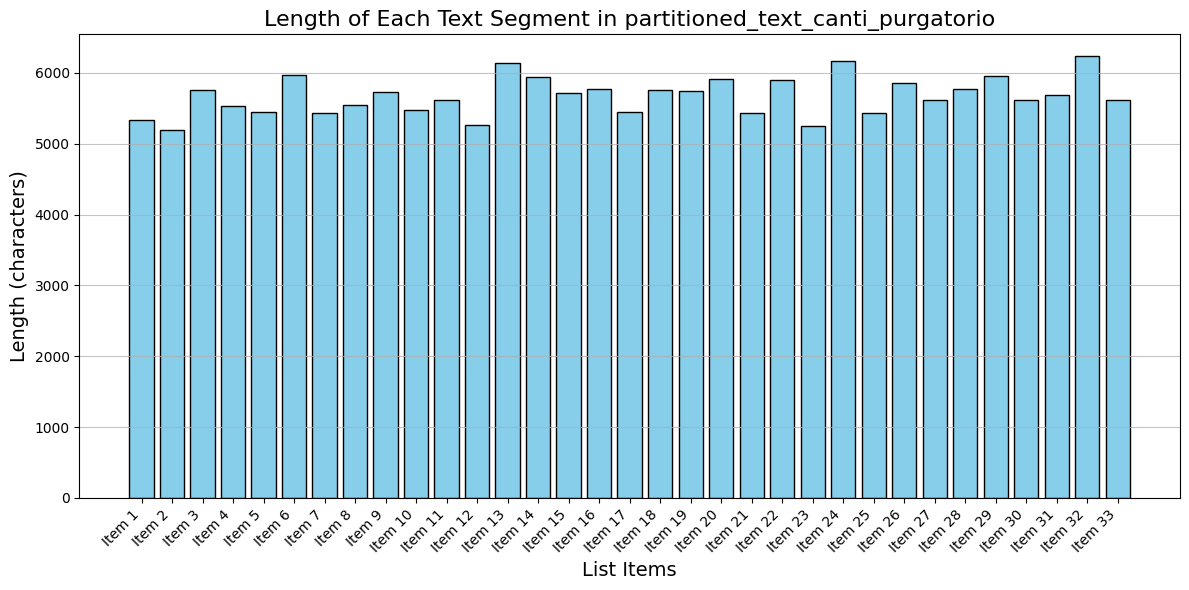

In [47]:
# Calculate the lengths of the items
lengths = [len(item) for item in partitioned_text_canti_purgatorio]

# Create x-axis labels
x_labels = [f"Item {i+1}" for i in range(len(partitioned_text_canti_purgatorio))]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x_labels, lengths, color='skyblue', edgecolor='black')
plt.title("Length of Each Text Segment in partitioned_text_canti_purgatorio", fontsize=16)
plt.xlabel("List Items", fontsize=14)
plt.ylabel("Length (characters)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

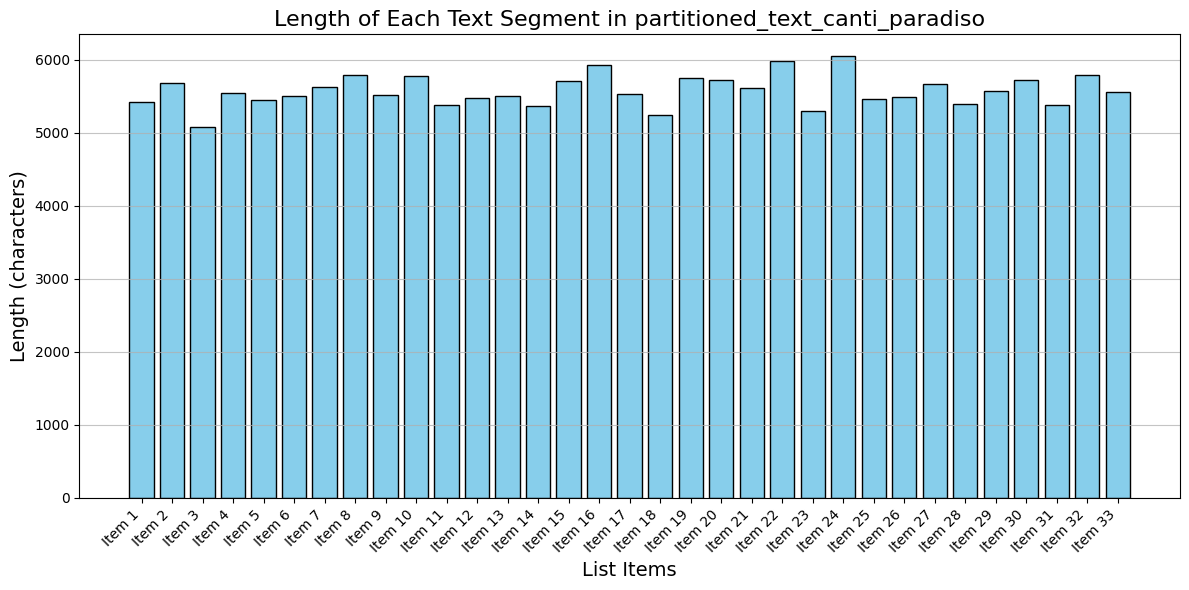

In [48]:
# Calculate the lengths of the items
lengths = [len(item) for item in partitioned_text_canti_paradiso]

# Create x-axis labels
x_labels = [f"Item {i+1}" for i in range(len(partitioned_text_canti_paradiso))]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x_labels, lengths, color='skyblue', edgecolor='black')
plt.title("Length of Each Text Segment in partitioned_text_canti_paradiso", fontsize=16)
plt.xlabel("List Items", fontsize=14)
plt.ylabel("Length (characters)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

In [49]:
# Initialize lists to store concatenated results
x_train_3, y_train_3 = [], []
x_val_3, y_val_3 = [], []
x_test_3, y_test_3 = [], []

partitioned_texts = [partitioned_text_canti_inferno, partitioned_text_canti_purgatorio, partitioned_text_canti_paradiso]
sentence_length = 30

# Loop through each partitioned_text and process it
for partitioned_text in partitioned_texts:
    x_train_partial, y_train_partial, x_val_partial, y_val_partial, x_test_partial, y_test_partial = prepare_data(partitioned_text, sentence_length)

    # Append the results to the lists
    x_train_3.append(x_train_partial)
    y_train_3.append(y_train_partial)
    x_val_3.append(x_val_partial)
    y_val_3.append(y_val_partial)
    x_test_3.append(x_test_partial)
    y_test_3.append(y_test_partial)

# Convert the lists to numpy arrays
x_train_3 = np.concatenate(x_train_3, axis=0)
y_train_3 = np.concatenate(y_train_3, axis=0)
x_val_3 = np.concatenate(x_val_3, axis=0)
y_val_3 = np.concatenate(y_val_3, axis=0)
x_test_3 = np.concatenate(x_test_3, axis=0)
y_test_3 = np.concatenate(y_test_3, axis=0)

# Print the shapes of the final datasets to verify
print(f"Training data shape: {x_train_3.shape}, {y_train_3.shape}")
print(f"Validation data shape: {x_val_3.shape}, {y_val_3.shape}")
print(f"Test data shape: {x_test_3.shape}, {y_test_3.shape}")

Training data shape: (110637, 30, 40), (110637, 40)
Validation data shape: (36227, 30, 40), (36227, 40)
Test data shape: (36264, 30, 40), (36264, 40)


The total amount of data is of course slightly reduced, relatively to the previous versions, because the data is split BEFORE generating the sentences and the one hot encodings, to avoid having overlaps between the differnet sets, that would induce a bias. Since this method splits every single 'canto', the data is split more frequently, and because of that, there are less total sentences.

## Third model's architecture and results

As a start, the model's architecture is still the same.

In [50]:
keras.utils.set_random_seed(seed)

model3 = Sequential()
model3.add(LSTM(128, input_shape=(sentence_length, len(chars))))
model3.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history3 = model3.fit(x_train_3, y_train_3,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_3, y_val_3),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1719 - loss: 3.0553 - val_accuracy: 0.2540 - val_loss: 2.6454
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3017 - loss: 2.3187 - val_accuracy: 0.3003 - val_loss: 2.4403
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3464 - loss: 2.0959 - val_accuracy: 0.3234 - val_loss: 2.2562
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3777 - loss: 1.9777 - val_accuracy: 0.3248 - val_loss: 2.2790
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4007 - loss: 1.8933 - val_accuracy: 0.3575 - val_loss: 2.1257
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4181 - loss: 1.8220 - val_accuracy: 0.3785 - val_loss: 2.0687
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4333 - loss: 1.7694 - val_accuracy: 0.3937 - val_loss: 1.9645
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4490 - loss: 1.7176 - val_accuracy: 0.4095 - v

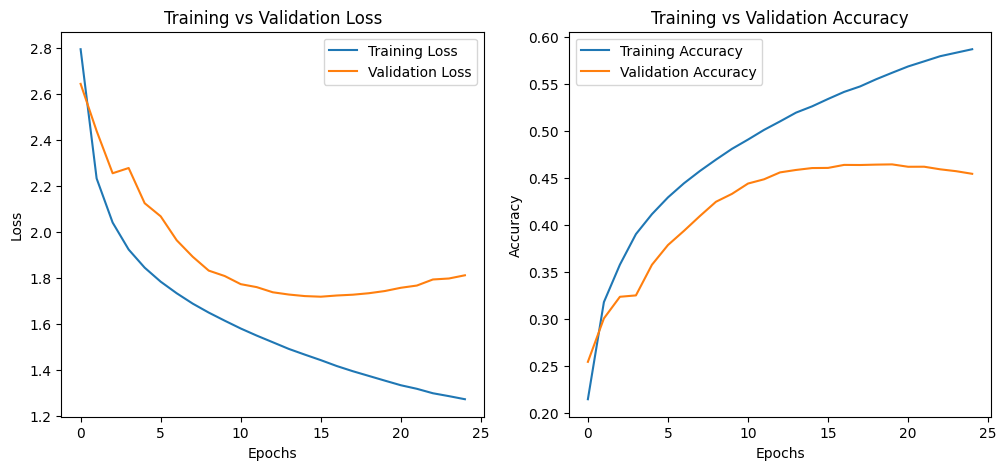

In [52]:
plot_training_metrics(history3)

In [53]:
y_pred = model3.predict(x_test_3) # Get the predictions

# Format class names for readability
class_names = [
    repr(indices_char[i]) for i in range(len(indices_char))
]  # Use repr() to show characters like ' ' and '\n'

# Convert predictions and true labels to class indices if necessary
y_pred_classes = y_pred.argmax(axis=-1)  # Convert probabilities to class indices
y_true = y_test_3.argmax(axis=-1)          # Convert one-hot encoded labels to class indices

# Print the classification report with formatted class names
print(classification_report(
    y_true,
    y_pred_classes,
    labels=list(indices_char.keys()),
    target_names=class_names,
    zero_division=0  # Suppresses warnings and assigns 0 for undefined metrics
))

1134/1134 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

        '\n'       0.62      0.79      0.69      1362
         ' '       0.72      0.87      0.79      6496
         '!'       0.00      0.00      0.00        18
         '"'       0.00      0.00      0.00         8
         "'"       0.27      0.10      0.14       547
         '('       0.00      0.00      0.00         1
         ')'       0.00      0.00      0.00         0
         ','       0.21      0.13      0.16       511
         '-'       0.00      0.00      0.00         0
         '.'       0.75      0.33      0.46       243
         ':'       0.53      0.14      0.22        64
         ';'       0.00      0.00      0.00       121
         '<'       0.74      0.78      0.76       113
         '>'       0.83      0.52      0.64       145
         '?'       0.00      0.00      0.00        23
         '`'       0.60      0.58      0.59       311
         'a'       0.39      0.41     

The performance seems quite similar, but I'm happier with this division, it probably has more potential, by working on the architecture.

It also seems to be reaching the best validation accuracy more quickly, altough it has much more overfitting.

## Better performance metrics and comparison

On the same model, I decided to calculate a couple more metrics (other than accuracy), to describe the results in different ways that could be better (or just more useful) to compare the later models.

In [54]:
def evaluate_model_performance(model, x_test, y_test, N=3):
    # Predict probabilities for the test set
    y_pred = model.predict(x_test, verbose=0)

    # Convert y_test (one-hot) to indices
    y_true_indices = np.argmax(y_test, axis=1)
    # Convert predicted probabilities to indices
    y_pred_indices = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = np.mean(y_true_indices == y_pred_indices) * 100

    # Calculate perplexity
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_test, y_pred)
    perplexity = np.exp(np.mean(cross_entropy))

    # Calculate top-N accuracy
    top_n_correct = 0
    for true_idx, pred_probs in zip(y_true_indices, y_pred):
        top_n_indices = np.argsort(pred_probs)[-N:]  # Get indices of top-N probabilities
        if true_idx in top_n_indices:
            top_n_correct += 1
    top_n_accuracy = (top_n_correct / len(y_test)) * 100

    # Return metrics
    return {
        "accuracy": accuracy,
        "perplexity": perplexity,
        "top_n_accuracy": top_n_accuracy,
    }

metrics = evaluate_model_performance(model3, x_test_3, y_test_3, N=3)
print("Model 3 performance metrics:")
print(f"Accuracy: {metrics['accuracy']:.2f}%")
print(f"Perplexity: {metrics['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics['top_n_accuracy']:.2f}%")


Model 3 performance metrics:
Accuracy: 45.78%
Perplexity: 5.80
Top-3 Accuracy: 70.33%


Accuracy: percentage of correct predictions.

Perplexity: measures prediction uncertainty, lower is better.

Top-N Accuracy: true character in top-N predictions.

In [55]:
total_chars = len(text)

# Get the top 3 most frequent characters
top_3 = char_counts.most_common(3)

# Initialize a sum for the percentages
total_percentage = 0

# Print results
print("Top 3 Most Frequent Characters:")
for char, count in top_3:
    percentage = (count / total_chars) * 100
    total_percentage += percentage
    print(f"Character: {repr(char)}, Count: {count}, Percentage: {percentage:.2f}%")

# Print the sum of the top 3 percentages
print(f"\nSum of Top 3 Percentages: {total_percentage:.2f}%")

Top 3 Most Frequent Characters:
Character: ' ', Count: 101150, Percentage: 18.12%
Character: 'e', Count: 48639, Percentage: 8.71%
Character: 'a', Count: 43487, Percentage: 7.79%

Sum of Top 3 Percentages: 34.62%


I then printed the frequencies of the top 3 characters in 'text', to be able to interpret the performance metrics (especially the top-3 accuracy).

In fact, if the accuracy and the top 3 accuracy were very close to the frequency of the first or the top 3 most frequent characters, that would mean that the model isn't learning almost anything.

This is not the case though, the performance is so far okay.

In [56]:
metrics1 = evaluate_model_performance(model, x_test, y_test, N=3)
print("Model 1 performance metrics:")
print(f"Accuracy: {metrics1['accuracy']:.2f}%")
print(f"Perplexity: {metrics1['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics1['top_n_accuracy']:.2f}%")

metrics2 = evaluate_model_performance(model2, x_test_2, y_test_2, N=3)
print("\nModel 2 performance metrics:")
print(f"Accuracy: {metrics2['accuracy']:.2f}%")
print(f"Perplexity: {metrics2['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics2['top_n_accuracy']:.2f}%")

metrics3 = evaluate_model_performance(model3, x_test_3, y_test_3, N=3)
print("\nModel 3 performance metrics:")
print(f"Accuracy: {metrics3['accuracy']:.2f}%")
print(f"Perplexity: {metrics3['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics3['top_n_accuracy']:.2f}%")

Model 1 performance metrics:
Accuracy: 45.59%
Perplexity: 5.80
Top-3 Accuracy: 70.57%

Model 2 performance metrics:
Accuracy: 46.18%
Perplexity: 5.37
Top-3 Accuracy: 70.95%

Model 3 performance metrics:
Accuracy: 45.78%
Perplexity: 5.80
Top-3 Accuracy: 70.33%


Lastly, I printed the performance metrics for the 3 models I created so far, to compare the results.

The first model (sequential split on the whole text) is understandably the worst performer, since it doesn't train on any of the 'paradiso' text that is used to test.

The second model (split on each one of the 3 'cantiche', corrisponding sub-splits appended) has a better accuracy, indicating that the split does make more sense and help improve the model's performance.

The third model (split on each 'canto', corrisponding sub-splits appended) actually performs worse. In the next sections I will figure out why, and fix the issue.

# Fourth model: reverse split attempt

In this section I simply edited the split_partition function used in the previous section to work in reverse, going from a sequential 60-20-20 split (train, val, test), to a sequential 20-20-60 split (test, val, train), still applied on each 'canto' separately, and then appending the corrisponding sub-splits.

The idea was to check if the lower performance was simply because the last part of each 'canto', that is used to test the model, is for some reason harder to predict.

In [57]:
def split_partition_reverse(partition, test_size=0.2, val_size=0.2, train_size=0.6):
    # Calculate the size of the split in terms of characters
    total_length = len(partition)
    test_end = math.floor(total_length * test_size)
    val_end = test_end + math.floor(total_length * val_size)

    # Split into test, validation, and train sets
    test_set = partition[:test_end]
    val_set = partition[test_end:val_end]
    train_set = partition[val_end:]

    return train_set, val_set, test_set

In [58]:
# Initialize lists to store concatenated results
x_train_4, y_train_4 = [], []
x_val_4, y_val_4 = [], []
x_test_4, y_test_4 = [], []

partitioned_texts = [partitioned_text_canti_inferno, partitioned_text_canti_purgatorio, partitioned_text_canti_paradiso]
sentence_length = 30

# Loop through each partitioned_text and process it
for partitioned_text in partitioned_texts:
    x_train_partial, y_train_partial, x_val_partial, y_val_partial, x_test_partial, y_test_partial = prepare_data(partitioned_text, sentence_length, split_partition_reverse)

    # Append the results to the lists
    x_train_4.append(x_train_partial)
    y_train_4.append(y_train_partial)
    x_val_4.append(x_val_partial)
    y_val_4.append(y_val_partial)
    x_test_4.append(x_test_partial)
    y_test_4.append(y_test_partial)

# Convert the lists to numpy arrays
x_train_4 = np.concatenate(x_train_4, axis=0)
y_train_4 = np.concatenate(y_train_4, axis=0)
x_val_4 = np.concatenate(x_val_4, axis=0)
y_val_4 = np.concatenate(y_val_4, axis=0)
x_test_4 = np.concatenate(x_test_4, axis=0)
y_test_4 = np.concatenate(y_test_4, axis=0)

# Print the shapes of the final datasets to verify
print(f"Training data shape: {x_train_4.shape}, {y_train_4.shape}")
print(f"Validation data shape: {x_val_4.shape}, {y_val_4.shape}")
print(f"Test data shape: {x_test_4.shape}, {y_test_4.shape}")

Training data shape: (110680, 30, 40), (110680, 40)
Validation data shape: (36227, 30, 40), (36227, 40)
Test data shape: (36227, 30, 40), (36227, 40)


In [59]:
keras.utils.set_random_seed(seed)

model4 = Sequential()
model4.add(LSTM(128, input_shape=(sentence_length, len(chars))))
model4.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history4 = model4.fit(x_train_4, y_train_4,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_4, y_val_4),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.1709 - loss: 3.0648 - val_accuracy: 0.2785 - val_loss: 2.4216
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3049 - loss: 2.3012 - val_accuracy: 0.3025 - val_loss: 2.2715
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3498 - loss: 2.0796 - val_accuracy: 0.3455 - val_loss: 2.0936
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3848 - loss: 1.9360 - val_accuracy: 0.3633 - val_loss: 2.0050
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4064 - loss: 1.8575 - val_accuracy: 0.3927 - val_loss: 1.9272
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4242 - loss: 1.7955 - val_accuracy: 0.4075 - val_loss: 1.8808
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4397 - loss: 1.7464 - val_accuracy: 0.4146 - val_loss: 1.8552
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4539 - loss: 1.7047 - val_accuracy: 0.4260 - v

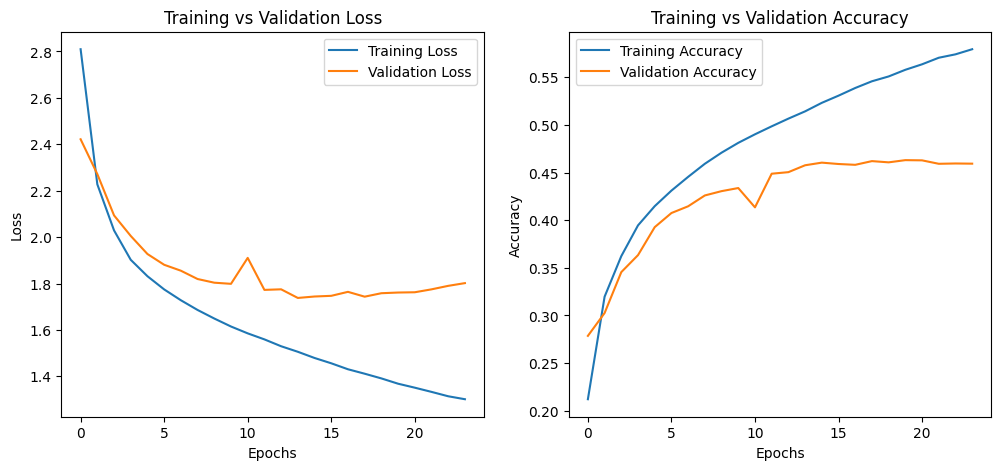

In [61]:
plot_training_metrics(history4)

I then calculated the performance metrics for this last model, and re-printed the previous performances for reference.

In [62]:
print("Model 1 performance metrics:")
print(f"Accuracy: {metrics1['accuracy']:.2f}%")
print(f"Perplexity: {metrics1['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics1['top_n_accuracy']:.2f}%")

print("\nModel 2 performance metrics:")
print(f"Accuracy: {metrics2['accuracy']:.2f}%")
print(f"Perplexity: {metrics2['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics2['top_n_accuracy']:.2f}%")

print("\nModel 3 performance metrics:")
print(f"Accuracy: {metrics3['accuracy']:.2f}%")
print(f"Perplexity: {metrics3['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics3['top_n_accuracy']:.2f}%")

metrics4 = evaluate_model_performance(model4, x_test_4, y_test_4, N=3)
print("Model 4 performance metrics:")
print(f"Accuracy: {metrics4['accuracy']:.2f}%")
print(f"Perplexity: {metrics4['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics4['top_n_accuracy']:.2f}%")


Model 1 performance metrics:
Accuracy: 45.59%
Perplexity: 5.80
Top-3 Accuracy: 70.57%

Model 2 performance metrics:
Accuracy: 46.18%
Perplexity: 5.37
Top-3 Accuracy: 70.95%

Model 3 performance metrics:
Accuracy: 45.78%
Perplexity: 5.80
Top-3 Accuracy: 70.33%
Model 4 performance metrics:
Accuracy: 45.69%
Perplexity: 5.68
Top-3 Accuracy: 70.90%


The performance is pretty much identical to the previous model, so I can comfortably exclude that the problem was only the 'higher difficulty' of the last part of each 'canto'.

# Fifth model: randomly-initialized split

This is the last section dedicated to the pre-processing and the correct division of the dataset.

In the section, the splits is a modified version of the third model, so it first splits in the 3 'cantiche', then splits each 'canto' and lastly it applied the train-val-test split on each canto, just like before.

The 60-20-20 split is then still applied sequentially on each 'canto', but instead of starting to split from the beginning of each canto, a random starting poing is chosen (from the beginning to the end of each canto, based on the length). This means that at some point, the split will reach the end of the text, and it will keep going by going back to the top, until it reaches the starting point.

Since a different starting point is applied to each 'canto', this randomness ensures that each one of the train-val-test sets contain different part of each 'canto', not always the first part, middle or ending parts.

## Data processing

In [63]:
def split_partition_random_start(partition, train_size=0.6, val_size=0.2, test_size=0.2):
    # Calculate the size of each split
    total_length = len(partition)
    train_length = math.floor(total_length * train_size)
    val_length = math.floor(total_length * val_size)
    test_length = total_length - train_length - val_length  # Remaining length for the test set

    # Generate a random starting point
    start_idx = random.randint(0, total_length - 1)

    # Create the splits by wrapping around the partition
    train_set = [partition[(start_idx + i) % total_length] for i in range(train_length)]
    val_set = [partition[(start_idx + train_length + i) % total_length] for i in range(val_length)]
    test_set = [partition[(start_idx + train_length + val_length + i) % total_length] for i in range(test_length)]

    # Add 2 newlines only in the set where the concatenation happens
    if train_length + val_length + test_length > total_length:
        if start_idx + train_length > total_length:
            train_set = train_set + ["\n"] * 2 + train_set[:train_length]
        elif start_idx + train_length + val_length > total_length:
            val_set = val_set + ["\n"] * 2 + val_set[:val_length]
        else:
            test_set = test_set + ["\n"] * 2 + test_set[:test_length]

    return train_set, val_set, test_set


This is a simplified version of what I actually wanted to do, to avoid having to rewrite multiple functions.

There is a minor issue, because when the model division reaches the end, it goes back to the top (as it should) but it concatenates. This means that when each set is divided into sentences, there will be sentences that start at the end of the 'divina commedia' and end at the start of the text. I have added a couple of newlines in the concatenation, to alleviate the problem, but as I said this is only a minor problem because there are only a few sentences that will have this issue.

In [64]:
# Initialize lists to store concatenated results
x_train_5, y_train_5 = [], []
x_val_5, y_val_5 = [], []
x_test_5, y_test_5 = [], []

partitioned_texts = [partitioned_text_canti_inferno, partitioned_text_canti_purgatorio, partitioned_text_canti_paradiso]
sentence_length = 30

# Loop through each partitioned_text and process it
for partitioned_text in partitioned_texts:
    x_train_partial, y_train_partial, x_val_partial, y_val_partial, x_test_partial, y_test_partial = prepare_data(partitioned_text, sentence_length, split_partition_random_start)

    # Append the results to the lists
    x_train_5.append(x_train_partial)
    y_train_5.append(y_train_partial)
    x_val_5.append(x_val_partial)
    y_val_5.append(y_val_partial)
    x_test_5.append(x_test_partial)
    y_test_5.append(y_test_partial)

# Convert the lists to numpy arrays
x_train_5 = np.concatenate(x_train_5, axis=0)
y_train_5 = np.concatenate(y_train_5, axis=0)
x_val_5 = np.concatenate(x_val_5, axis=0)
y_val_5 = np.concatenate(y_val_5, axis=0)
x_test_5 = np.concatenate(x_test_5, axis=0)
y_test_5 = np.concatenate(y_test_5, axis=0)

# Print the shapes of the final datasets to verify
print(f"Training data shape: {x_train_5.shape}, {y_train_5.shape}")
print(f"Validation data shape: {x_val_5.shape}, {y_val_5.shape}")
print(f"Test data shape: {x_test_5.shape}, {y_test_5.shape}")

Training data shape: (110637, 30, 40), (110637, 40)
Validation data shape: (36227, 30, 40), (36227, 40)
Test data shape: (36264, 30, 40), (36264, 40)


## Fifth model's architecture and results

In [65]:
keras.utils.set_random_seed(seed)

model5 = Sequential()
model5.add(LSTM(128, input_shape=(sentence_length, len(chars))))
model5.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model5.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history5 = model5.fit(x_train_5, y_train_5,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_5, y_val_5),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1691 - loss: 3.0729 - val_accuracy: 0.2240 - val_loss: 2.4929
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3020 - loss: 2.3076 - val_accuracy: 0.2839 - val_loss: 2.3092
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3474 - loss: 2.0862 - val_accuracy: 0.3186 - val_loss: 2.1798
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3809 - loss: 1.9565 - val_accuracy: 0.3548 - val_loss: 2.0480
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4049 - loss: 1.8701 - val_accuracy: 0.3767 - val_loss: 1.9629
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4245 - loss: 1.8049 - val_accuracy: 0.3907 - val_loss: 1.9444
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4377 - loss: 1.7567 - val_accuracy: 0.3990 - val_loss: 1.9510
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4517 - loss: 1.7149 - val_accuracy: 0.4069 - v

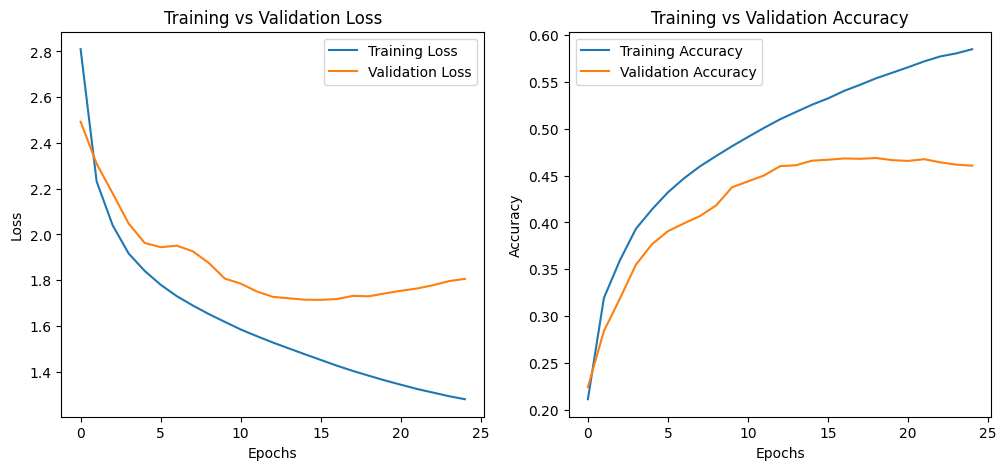

In [67]:
plot_training_metrics(history5)

In [68]:
print("Model 1 performance metrics:")
print(f"Accuracy: {metrics1['accuracy']:.2f}%")
print(f"Perplexity: {metrics1['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics1['top_n_accuracy']:.2f}%")

print("\nModel 2 performance metrics:")
print(f"Accuracy: {metrics2['accuracy']:.2f}%")
print(f"Perplexity: {metrics2['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics2['top_n_accuracy']:.2f}%")

print("\nModel 3 performance metrics:")
print(f"Accuracy: {metrics3['accuracy']:.2f}%")
print(f"Perplexity: {metrics3['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics3['top_n_accuracy']:.2f}%")

print("\nModel 4 performance metrics:")
print(f"Accuracy: {metrics4['accuracy']:.2f}%")
print(f"Perplexity: {metrics4['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics4['top_n_accuracy']:.2f}%")

metrics5 = evaluate_model_performance(model5, x_test_5, y_test_5, N=3)
print("\nModel 5 performance metrics:")
print(f"Accuracy: {metrics5['accuracy']:.2f}%")
print(f"Perplexity: {metrics5['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics5['top_n_accuracy']:.2f}%")

Model 1 performance metrics:
Accuracy: 45.59%
Perplexity: 5.80
Top-3 Accuracy: 70.57%

Model 2 performance metrics:
Accuracy: 46.18%
Perplexity: 5.37
Top-3 Accuracy: 70.95%

Model 3 performance metrics:
Accuracy: 45.78%
Perplexity: 5.80
Top-3 Accuracy: 70.33%

Model 4 performance metrics:
Accuracy: 45.69%
Perplexity: 5.68
Top-3 Accuracy: 70.90%

Model 5 performance metrics:
Accuracy: 46.58%
Perplexity: 5.56
Top-3 Accuracy: 71.13%


The performance is finally better, meaning that this approach with this added randomness is the best approach applied so far. I will now be using this dataset division to improve the model, by working on the architecture.

Of course the performance increase isn't much, but hopefully this is limited by the model's architecture.

# Sixth model: added LSTM and dense layers

The following model is the best I could reach, by adding more LSTM and dense layers. Any more or any less would result in a worse performance. However, the performance increase is still very small.

I also changed the optimizer to Adam, with a higher learning rate, so the model needs less epochs to converge.

In [69]:
keras.utils.set_random_seed(seed)

model6 = Sequential()
model6.add(Dense(64, activation='relu', input_shape=(sentence_length, len(chars))))
model6.add(LSTM(128, return_sequences=True))
model6.add(Dense(64, activation='relu'))
model6.add(LSTM(128))
model6.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model6.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model6.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 30, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 30, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,672 (834.66 KB)

 Trainable params: 213,672 (834.66 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history6 = model6.fit(x_train_5, y_train_5,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_5, y_val_5),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.1553 - loss: 3.1020 - val_accuracy: 0.2413 - val_loss: 2.5719
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.2566 - loss: 2.4882 - val_accuracy: 0.2905 - val_loss: 2.2853
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.3137 - loss: 2.2137 - val_accuracy: 0.3592 - val_loss: 2.0647
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3668 - loss: 2.0081 - val_accuracy: 0.3874 - val_loss: 1.9560
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3945 - loss: 1.9137 - val_accuracy: 0.4108 - val_loss: 1.8543
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.4150 - loss: 1.8300 - val_accuracy: 0.4222 - val_loss: 1.8146
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.4314 - loss: 1.7734 - val_accuracy: 0.4396 - val_loss: 1.7728
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.4420 - loss: 1.7342 - val_accuracy: 0.4510 - v

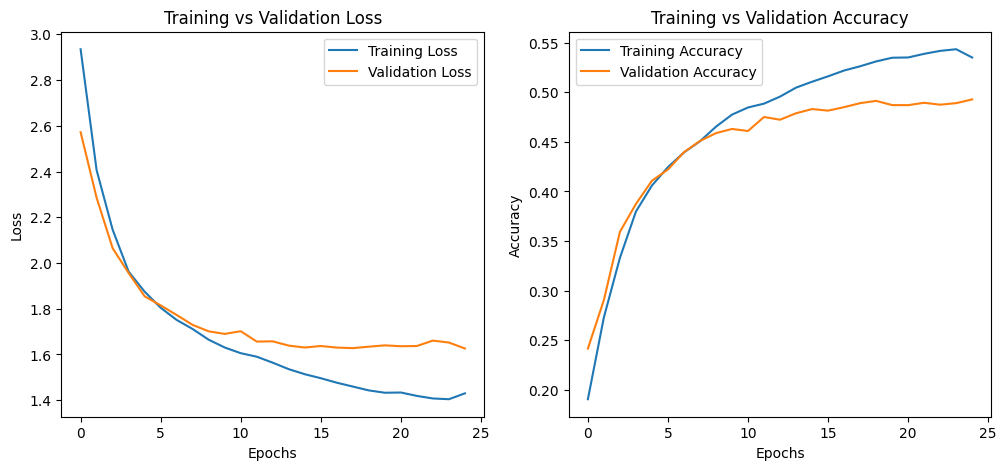

In [71]:
plot_training_metrics(history6)

In [72]:
print("Model 5 ('starting' model with the best data split) performance metrics:")
print(f"Accuracy: {metrics5['accuracy']:.2f}%")
print(f"Perplexity: {metrics5['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics5['top_n_accuracy']:.2f}%")

metrics6 = evaluate_model_performance(model6, x_test_5, y_test_5, N=3)
print("\nModel 6 (added LSTM & dense) performance metrics:")
print(f"Accuracy: {metrics6['accuracy']:.2f}%")
print(f"Perplexity: {metrics6['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics6['top_n_accuracy']:.2f}%")

Model 5 ('starting' model with the best data split) performance metrics:
Accuracy: 46.58%
Perplexity: 5.56
Top-3 Accuracy: 71.13%

Model 6 (added LSTM & dense) performance metrics:
Accuracy: 48.76%
Perplexity: 5.11
Top-3 Accuracy: 72.91%


The performance increased. This is the sweet-spot I found, trying many different combinations of LSTM and dense layers, with different sizes.

# Seventh model: dropout

Starting from the sixth model, I added dropouts.

In [73]:
keras.utils.set_random_seed(seed)

model7 = Sequential()
model7.add(Dense(64, activation='relu', input_shape=(sentence_length, len(chars))))
model7.add(Dropout(0.1))  # Adding dropout
model7.add(LSTM(128, return_sequences=True))
model7.add(Dropout(0.1))  # Adding dropout
model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.1))  # Adding dropout
model7.add(LSTM(128))
model7.add(Dropout(0.1))  # Adding dropout
model7.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model7.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 30, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 30, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,672 (834.66 KB)

 Trainable params: 213,672 (834.66 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history7 = model7.fit(x_train_5, y_train_5,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_5, y_val_5),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.1559 - loss: 3.1021 - val_accuracy: 0.2620 - val_loss: 2.5381
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.2613 - loss: 2.4708 - val_accuracy: 0.3106 - val_loss: 2.2457
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3102 - loss: 2.2385 - val_accuracy: 0.3523 - val_loss: 2.0893
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3450 - loss: 2.0965 - val_accuracy: 0.3794 - val_loss: 1.9806
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.3699 - loss: 2.0080 - val_accuracy: 0.3955 - val_loss: 1.9149
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.3803 - loss: 1.9541 - val_accuracy: 0.4081 - val_loss: 1.8648
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3939 - loss: 1.9060 - val_accuracy: 0.4205 - val_loss: 1.8198
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4040 - loss: 1.8663 - val_accuracy: 0.4319 - v

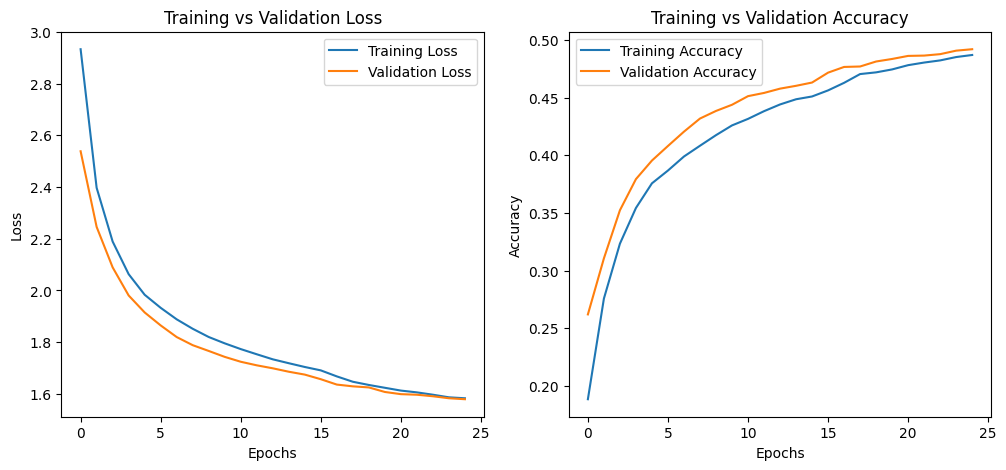

In [75]:
plot_training_metrics(history7)

In [76]:
print("Model 5 ('starting' model with the best data split) performance metrics:")
print(f"Accuracy: {metrics5['accuracy']:.2f}%")
print(f"Perplexity: {metrics5['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics5['top_n_accuracy']:.2f}%")

print("\nModel 6 (added LSTM & dense) performance metrics:")
print(f"Accuracy: {metrics6['accuracy']:.2f}%")
print(f"Perplexity: {metrics6['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics6['top_n_accuracy']:.2f}%")

metrics7 = evaluate_model_performance(model7, x_test_5, y_test_5, N=3)
print("\nModel 7 (added LSTM & dense + dropout) performance metrics:")
print(f"Accuracy: {metrics7['accuracy']:.2f}%")
print(f"Perplexity: {metrics7['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics7['top_n_accuracy']:.2f}%")

Model 5 ('starting' model with the best data split) performance metrics:
Accuracy: 46.58%
Perplexity: 5.56
Top-3 Accuracy: 71.13%

Model 6 (added LSTM & dense) performance metrics:
Accuracy: 48.76%
Perplexity: 5.11
Top-3 Accuracy: 72.91%

Model 7 (added LSTM & dense + dropout) performance metrics:
Accuracy: 49.02%
Perplexity: 4.86
Top-3 Accuracy: 73.74%


By optimizing the amound of dropouts, the performance increased slightly and the overfitting is eliminated.

# Eighth model: GRU attempt

In this model I have replaced all of the LSTM layers with GRU layers. As we have seen in class, using GRU instead of LSTM doesn't guarentee a performance increase, it's just something that can be attempted, to see if it works better in that specific model and that specific task.


In [77]:
keras.utils.set_random_seed(seed)

model8 = Sequential()
model8.add(Dense(64, activation='relu', input_shape=(sentence_length, len(chars))))
model8.add(Dropout(0.1))
model8.add(GRU(128, return_sequences=True))
model8.add(Dropout(0.1))
model8.add(Dense(64, activation='relu'))
model8.add(Dropout(0.1))
model8.add(GRU(128))
model8.add(Dropout(0.1))
model8.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model8.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 30, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 30, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 30, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,032 (644.66 KB)

 Trainable params: 165,032 (644.66 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history8 = model8.fit(x_train_5, y_train_5,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_5, y_val_5),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.1629 - loss: 3.0529 - val_accuracy: 0.3297 - val_loss: 2.1867
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.3340 - loss: 2.1450 - val_accuracy: 0.3853 - val_loss: 1.9444
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3764 - loss: 1.9697 - val_accuracy: 0.4101 - val_loss: 1.8426
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.3982 - loss: 1.8828 - val_accuracy: 0.4362 - val_loss: 1.7647
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4211 - loss: 1.8084 - val_accuracy: 0.4518 - val_loss: 1.7221
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.4353 - loss: 1.7620 - val_accuracy: 0.4658 - val_loss: 1.6791
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4513 - loss: 1.7146 - val_accuracy: 0.4723 - val_loss: 1.6648
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4560 - loss: 1.6988 - val_accuracy: 0.4774 - v

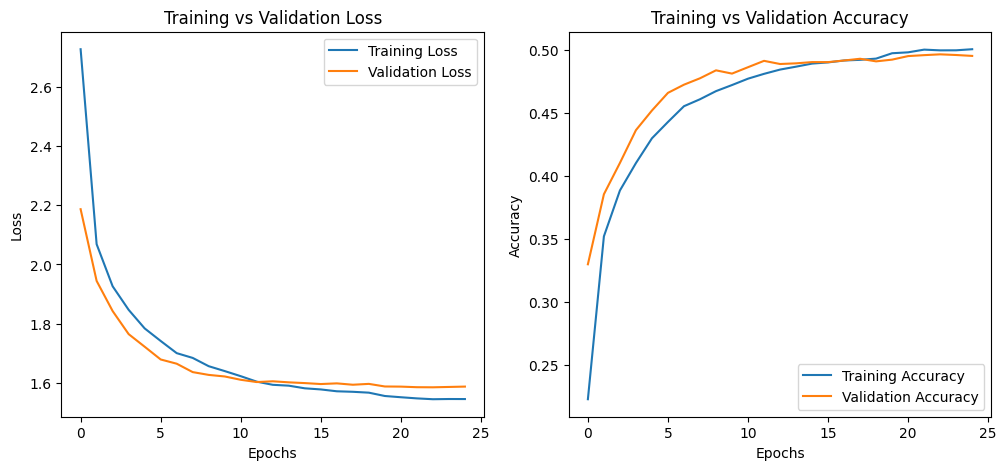

In [79]:
plot_training_metrics(history8)

In [80]:
print("Model 5 ('starting' model with the best data split) performance metrics:")
print(f"Accuracy: {metrics5['accuracy']:.2f}%")
print(f"Perplexity: {metrics5['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics5['top_n_accuracy']:.2f}%")

print("\nModel 6 (added LSTM & dense) performance metrics:")
print(f"Accuracy: {metrics6['accuracy']:.2f}%")
print(f"Perplexity: {metrics6['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics6['top_n_accuracy']:.2f}%")

print("\nModel 7 (added LSTM & dense + dropout) performance metrics:")
print(f"Accuracy: {metrics7['accuracy']:.2f}%")
print(f"Perplexity: {metrics7['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics7['top_n_accuracy']:.2f}%")

metrics8 = evaluate_model_performance(model8, x_test_5, y_test_5, N=3)
print("\nModel 8 (GRU + dropout) performance metrics:")
print(f"Accuracy: {metrics8['accuracy']:.2f}%")
print(f"Perplexity: {metrics8['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics8['top_n_accuracy']:.2f}%")

Model 5 ('starting' model with the best data split) performance metrics:
Accuracy: 46.58%
Perplexity: 5.56
Top-3 Accuracy: 71.13%

Model 6 (added LSTM & dense) performance metrics:
Accuracy: 48.76%
Perplexity: 5.11
Top-3 Accuracy: 72.91%

Model 7 (added LSTM & dense + dropout) performance metrics:
Accuracy: 49.02%
Perplexity: 4.86
Top-3 Accuracy: 73.74%

Model 8 (GRU + dropout) performance metrics:
Accuracy: 49.62%
Perplexity: 4.89
Top-3 Accuracy: 73.76%


In this case the performance increased slightly. This means LSTMs shouldn't be ruled out after the next improvements because after applying more changes, LSTM might work better.

# Ninth model: chunk length

## Data processing

In [81]:
# Initialize lists to store concatenated results
x_train_9, y_train_9 = [], []
x_val_9, y_val_9 = [], []
x_test_9, y_test_9 = [], []

partitioned_texts = [partitioned_text_canti_inferno, partitioned_text_canti_purgatorio, partitioned_text_canti_paradiso]
sentence_length = 45

# Loop through each partitioned_text and process it
for partitioned_text in partitioned_texts:
    x_train_partial, y_train_partial, x_val_partial, y_val_partial, x_test_partial, y_test_partial = prepare_data(partitioned_text, sentence_length, split_partition_random_start)

    # Append the results to the lists
    x_train_9.append(x_train_partial)
    y_train_9.append(y_train_partial)
    x_val_9.append(x_val_partial)
    y_val_9.append(y_val_partial)
    x_test_9.append(x_test_partial)
    y_test_9.append(y_test_partial)

# Convert the lists to numpy arrays
x_train_9 = np.concatenate(x_train_9, axis=0)
y_train_9 = np.concatenate(y_train_9, axis=0)
x_val_9 = np.concatenate(x_val_9, axis=0)
y_val_9 = np.concatenate(y_val_9, axis=0)
x_test_9 = np.concatenate(x_test_9, axis=0)
y_test_9 = np.concatenate(y_test_9, axis=0)

# Print the shapes of the final datasets to verify
print(f"Training data shape: {x_train_9.shape}, {y_train_9.shape}")
print(f"Validation data shape: {x_val_9.shape}, {y_val_9.shape}")
print(f"Test data shape: {x_test_9.shape}, {y_test_9.shape}")

Training data shape: (110137, 45, 40), (110137, 40)
Validation data shape: (35727, 45, 40), (35727, 40)
Test data shape: (35764, 45, 40), (35764, 40)


## Ninth model architecture and results

In [82]:
keras.utils.set_random_seed(seed)

model9 = Sequential()
model9.add(Dense(64, activation='relu', input_shape=(sentence_length, len(chars))))
model9.add(Dropout(0.1))
model9.add(GRU(128, return_sequences=True))
model9.add(Dropout(0.1))
model9.add(Dense(64, activation='relu'))
model9.add(Dropout(0.1))
model9.add(GRU(128))
model9.add(Dropout(0.1))
model9.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model9.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model9.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 45, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 45, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 45, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,032 (644.66 KB)

 Trainable params: 165,032 (644.66 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history9 = model9.fit(x_train_9, y_train_9,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_9, y_val_9),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1613 - loss: 3.0583 - val_accuracy: 0.3338 - val_loss: 2.1732
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3358 - loss: 2.1384 - val_accuracy: 0.3973 - val_loss: 1.9007
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.3891 - loss: 1.9199 - val_accuracy: 0.4350 - val_loss: 1.7755
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.4176 - loss: 1.8119 - val_accuracy: 0.4556 - val_loss: 1.7084
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4387 - loss: 1.7465 - val_accuracy: 0.4686 - val_loss: 1.6649
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4539 - loss: 1.6947 - val_accuracy: 0.4745 - val_loss: 1.6449
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4615 - loss: 1.6664 - val_accuracy: 0.4808 - val_loss: 1.6267
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.4708 - loss: 1.6404 - val_accuracy: 0.4879 - v

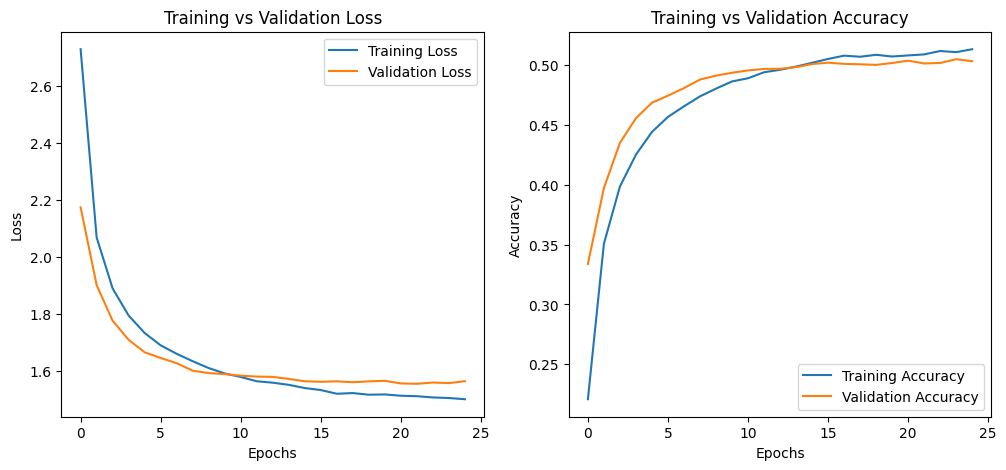

In [84]:
plot_training_metrics(history9)

In [85]:
print("Model 5 ('starting' model with the best data split) performance metrics:")
print(f"Accuracy: {metrics5['accuracy']:.2f}%")
print(f"Perplexity: {metrics5['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics5['top_n_accuracy']:.2f}%")

print("\nModel 6 (added LSTM & dense) performance metrics:")
print(f"Accuracy: {metrics6['accuracy']:.2f}%")
print(f"Perplexity: {metrics6['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics6['top_n_accuracy']:.2f}%")

print("\nModel 7 (added LSTM & dense + dropout) performance metrics:")
print(f"Accuracy: {metrics7['accuracy']:.2f}%")
print(f"Perplexity: {metrics7['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics7['top_n_accuracy']:.2f}%")

print("\nModel 8 (GRU + dropout) performance metrics:")
print(f"Accuracy: {metrics8['accuracy']:.2f}%")
print(f"Perplexity: {metrics8['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics8['top_n_accuracy']:.2f}%")

metrics9 = evaluate_model_performance(model9, x_test_9, y_test_9, N=3)
print("\nModel 9 (GRU + sentence length) performance metrics:")
print(f"Accuracy: {metrics9['accuracy']:.2f}%")
print(f"Perplexity: {metrics9['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics9['top_n_accuracy']:.2f}%")

Model 5 ('starting' model with the best data split) performance metrics:
Accuracy: 46.58%
Perplexity: 5.56
Top-3 Accuracy: 71.13%

Model 6 (added LSTM & dense) performance metrics:
Accuracy: 48.76%
Perplexity: 5.11
Top-3 Accuracy: 72.91%

Model 7 (added LSTM & dense + dropout) performance metrics:
Accuracy: 49.02%
Perplexity: 4.86
Top-3 Accuracy: 73.74%

Model 8 (GRU + dropout) performance metrics:
Accuracy: 49.62%
Perplexity: 4.89
Top-3 Accuracy: 73.76%

Model 9 (GRU + sentence length) performance metrics:
Accuracy: 50.67%
Perplexity: 4.68
Top-3 Accuracy: 74.54%


Test set accuracy

| Sentence Length | Accuracy    |
|-----------------|-------------|
| 20              | 49.05%      |
| 25              | 49.36%      |
| 30 (starting)   | 49.62%      |
| 35              | 50.15%      |
| 40              | 49.47%      |
| 45              | 50.67%      |
| 50              | 49.71%      |
| 60              | 50.47%      |
| 75              | 50.30%      |
| 100             | 49.96%      |


Reducing the sentence length worsens the performance (as expected).

Increasing the sentence length improves the performance a bit, until it becomes a little inconsistent (understandably), it's probably just because of luck that some lengths perform better than other.

I will take 45 as the best one, but it's important to note (again) that by changing other things next, this number might not be the optimal one anymore.

# Tenth model: stride

In this section I improved the previous best model (sentence length of 45) by changing the stride during the data preparation.

## Data processing

In [86]:
# Initialize lists to store concatenated results
x_train_10, y_train_10 = [], []
x_val_10, y_val_10 = [], []
x_test_10, y_test_10 = [], []

partitioned_texts = [partitioned_text_canti_inferno, partitioned_text_canti_purgatorio, partitioned_text_canti_paradiso]
sentence_length = 45

# Loop through each partitioned_text and process it
for partitioned_text in partitioned_texts:
    x_train_partial, y_train_partial, x_val_partial, y_val_partial, x_test_partial, y_test_partial = prepare_data(partitioned_text, sentence_length, split_partition_random_start, stride=1)

    # Append the results to the lists
    x_train_10.append(x_train_partial)
    y_train_10.append(y_train_partial)
    x_val_10.append(x_val_partial)
    y_val_10.append(y_val_partial)
    x_test_10.append(x_test_partial)
    y_test_10.append(y_test_partial)

# Convert the lists to numpy arrays
x_train_10 = np.concatenate(x_train_10, axis=0)
y_train_10 = np.concatenate(y_train_10, axis=0)
x_val_10 = np.concatenate(x_val_10, axis=0)
y_val_10 = np.concatenate(y_val_10, axis=0)
x_test_10 = np.concatenate(x_test_10, axis=0)
y_test_10 = np.concatenate(y_test_10, axis=0)

# Print the shapes of the final datasets to verify
print(f"Training data shape: {x_train_10.shape}, {y_train_10.shape}")
print(f"Validation data shape: {x_val_10.shape}, {y_val_10.shape}")
print(f"Test data shape: {x_test_10.shape}, {y_test_10.shape}")

Training data shape: (330316, 45, 40), (330316, 40)
Validation data shape: (107077, 45, 40), (107077, 40)
Test data shape: (107198, 45, 40), (107198, 40)


## Tenth model architecture and results

In [87]:
keras.utils.set_random_seed(seed)

model10 = Sequential()
model10.add(Dense(64, activation='relu', input_shape=(sentence_length, len(chars))))
model10.add(Dropout(0.1))
model10.add(GRU(128, return_sequences=True))
model10.add(Dropout(0.1))
model10.add(Dense(64, activation='relu'))
model10.add(Dropout(0.1))
model10.add(GRU(128))
model10.add(Dropout(0.1))
model10.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model10.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model10.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 45, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 45, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 45, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,032 (644.66 KB)

 Trainable params: 165,032 (644.66 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history10 = model10.fit(x_train_10, y_train_10,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_10, y_val_10),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.2410 - loss: 2.6291 - val_accuracy: 0.4290 - val_loss: 1.7772
Epoch 2/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.4215 - loss: 1.8084 - val_accuracy: 0.4719 - val_loss: 1.6340
Epoch 3/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.4580 - loss: 1.6884 - val_accuracy: 0.4941 - val_loss: 1.5701
Epoch 4/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.4737 - loss: 1.6363 - val_accuracy: 0.5021 - val_loss: 1.5401
Epoch 5/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.4817 - loss: 1.6066 - val_accuracy: 0.5082 - val_loss: 1.5269
Epoch 6/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.4869 - loss: 1.5895 - val_accuracy: 0.5108 - val_loss: 1.5144
Epoch 7/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.4910 - loss: 1.5757 - val_accuracy: 0.5142 - val_loss: 1.5016
Epoch 8/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.4944 - loss: 1.5649 - 

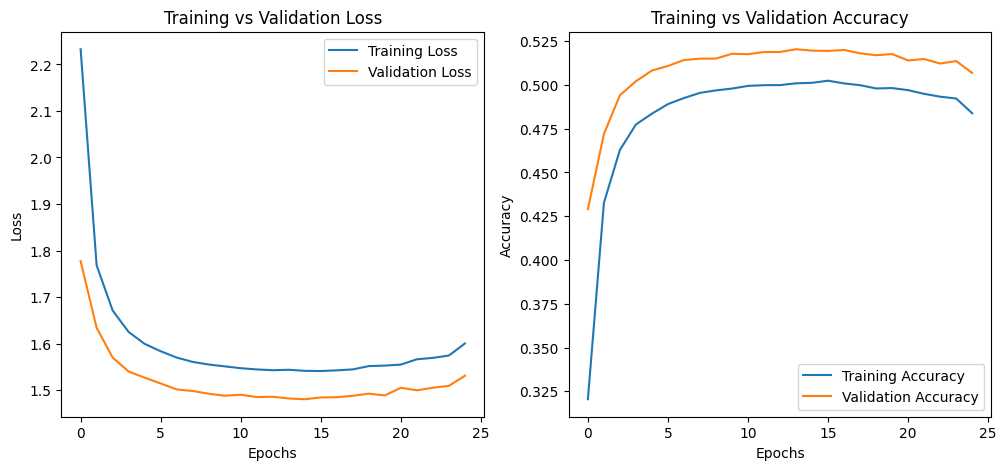

In [89]:
plot_training_metrics(history10)

In [90]:
print("Model 5 ('starting' model with the best data split) performance metrics:")
print(f"Accuracy: {metrics5['accuracy']:.2f}%")
print(f"Perplexity: {metrics5['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics5['top_n_accuracy']:.2f}%")

print("\nModel 6 (added LSTM & dense) performance metrics:")
print(f"Accuracy: {metrics6['accuracy']:.2f}%")
print(f"Perplexity: {metrics6['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics6['top_n_accuracy']:.2f}%")

print("\nModel 7 (added LSTM & dense + dropout) performance metrics:")
print(f"Accuracy: {metrics7['accuracy']:.2f}%")
print(f"Perplexity: {metrics7['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics7['top_n_accuracy']:.2f}%")

print("\nModel 8 (GRU + dropout) performance metrics:")
print(f"Accuracy: {metrics8['accuracy']:.2f}%")
print(f"Perplexity: {metrics8['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics8['top_n_accuracy']:.2f}%")

print("\nModel 9 (GRU + sentence length) performance metrics:")
print(f"Accuracy: {metrics9['accuracy']:.2f}%")
print(f"Perplexity: {metrics9['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics9['top_n_accuracy']:.2f}%")

metrics10 = evaluate_model_performance(model10, x_test_10, y_test_10, N=3)
print("\nModel 10 (GRU + sentence length + stride) performance metrics:")
print(f"Accuracy: {metrics10['accuracy']:.2f}%")
print(f"Perplexity: {metrics10['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics10['top_n_accuracy']:.2f}%")

Model 5 ('starting' model with the best data split) performance metrics:
Accuracy: 46.58%
Perplexity: 5.56
Top-3 Accuracy: 71.13%

Model 6 (added LSTM & dense) performance metrics:
Accuracy: 48.76%
Perplexity: 5.11
Top-3 Accuracy: 72.91%

Model 7 (added LSTM & dense + dropout) performance metrics:
Accuracy: 49.02%
Perplexity: 4.86
Top-3 Accuracy: 73.74%

Model 8 (GRU + dropout) performance metrics:
Accuracy: 49.62%
Perplexity: 4.89
Top-3 Accuracy: 73.76%

Model 9 (GRU + sentence length) performance metrics:
Accuracy: 50.67%
Perplexity: 4.68
Top-3 Accuracy: 74.54%

Model 10 (GRU + sentence length + stride) performance metrics:
Accuracy: 51.97%
Perplexity: 4.40
Top-3 Accuracy: 76.10%


| Stride | Performance |
|--------|-------------|
| 3      | 50.67%      |
| 2      | 51.30%      |
| 1      | 51.97%      |

It's clear how a lower stride helps the performance, since a lower stride means more data in each set. Aiming for the best performance, I picked a stride of 1.

However, although the model's architecure hasn't changed, the training curves show clear signs of underfitting.

# Eleventh model: underfitting fix

In this model I simply reduced the dropouts, to remove the underfitting.

In [91]:
keras.utils.set_random_seed(seed)

model11 = Sequential()
model11.add(Dense(64, activation='relu', input_shape=(sentence_length, len(chars))))
model11.add(Dropout(0.01))
model11.add(GRU(128, return_sequences=True))
model11.add(Dropout(0.01))
model11.add(Dense(64, activation='relu'))
model11.add(Dropout(0.01))
model11.add(GRU(128))
model11.add(Dropout(0.01))
model11.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model11.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model11.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 45, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 45, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 45, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,032 (644.66 KB)

 Trainable params: 165,032 (644.66 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history11 = model11.fit(x_train_10, y_train_10,
                      batch_size = 2048,
                      epochs = 25,
                      validation_data = (x_val_10, y_val_10),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.2512 - loss: 2.5839 - val_accuracy: 0.4381 - val_loss: 1.7531
Epoch 2/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.4421 - loss: 1.7345 - val_accuracy: 0.4836 - val_loss: 1.6021
Epoch 3/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.4829 - loss: 1.5970 - val_accuracy: 0.5047 - val_loss: 1.5397
Epoch 4/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.5031 - loss: 1.5360 - val_accuracy: 0.5162 - val_loss: 1.5084
Epoch 5/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5142 - loss: 1.4986 - val_accuracy: 0.5172 - val_loss: 1.5002
Epoch 6/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.5216 - loss: 1.4748 - val_accuracy: 0.5204 - val_loss: 1.4918
Epoch 7/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.5247 - loss: 1.4601 - val_accuracy: 0.5223 - val_loss: 1.4827
Epoch 8/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.5294 - loss: 1.4472 - 

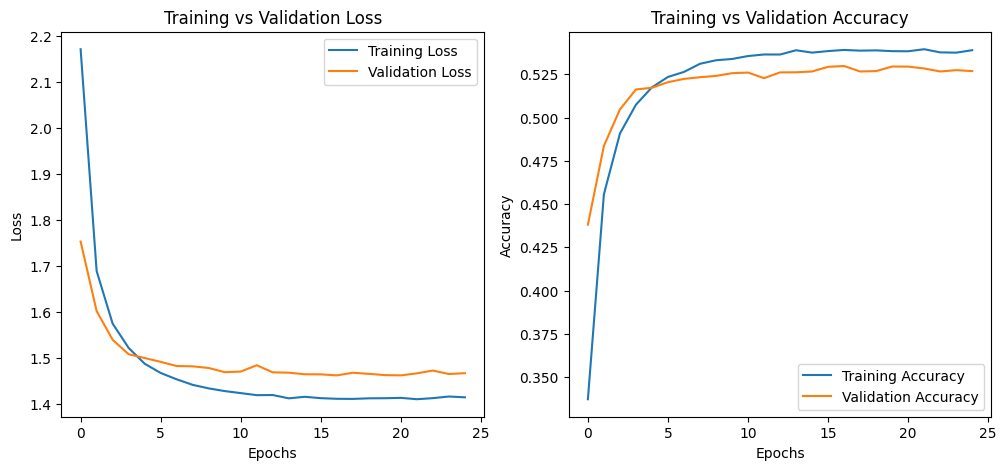

In [93]:
plot_training_metrics(history11)

In [94]:
print("Model 5 ('starting' model with the best data split) performance metrics:")
print(f"Accuracy: {metrics5['accuracy']:.2f}%")
print(f"Perplexity: {metrics5['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics5['top_n_accuracy']:.2f}%")

print("\nModel 6 (added LSTM & dense) performance metrics:")
print(f"Accuracy: {metrics6['accuracy']:.2f}%")
print(f"Perplexity: {metrics6['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics6['top_n_accuracy']:.2f}%")

print("\nModel 7 (added LSTM & dense + dropout) performance metrics:")
print(f"Accuracy: {metrics7['accuracy']:.2f}%")
print(f"Perplexity: {metrics7['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics7['top_n_accuracy']:.2f}%")

print("\nModel 8 (GRU + dropout) performance metrics:")
print(f"Accuracy: {metrics8['accuracy']:.2f}%")
print(f"Perplexity: {metrics8['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics8['top_n_accuracy']:.2f}%")

print("\nModel 9 (GRU + sentence length) performance metrics:")
print(f"Accuracy: {metrics9['accuracy']:.2f}%")
print(f"Perplexity: {metrics9['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics9['top_n_accuracy']:.2f}%")

print("\nModel 10 (GRU + sentence length + stride) performance metrics:")
print(f"Accuracy: {metrics10['accuracy']:.2f}%")
print(f"Perplexity: {metrics10['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics10['top_n_accuracy']:.2f}%")

metrics11 = evaluate_model_performance(model11, x_test_10, y_test_10, N=3)
print("\nModel 11 (GRU + sentence length + stride + reduced dropouts) performance metrics:")
print(f"Accuracy: {metrics11['accuracy']:.2f}%")
print(f"Perplexity: {metrics11['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics11['top_n_accuracy']:.2f}%")

Model 5 ('starting' model with the best data split) performance metrics:
Accuracy: 46.58%
Perplexity: 5.56
Top-3 Accuracy: 71.13%

Model 6 (added LSTM & dense) performance metrics:
Accuracy: 48.76%
Perplexity: 5.11
Top-3 Accuracy: 72.91%

Model 7 (added LSTM & dense + dropout) performance metrics:
Accuracy: 49.02%
Perplexity: 4.86
Top-3 Accuracy: 73.74%

Model 8 (GRU + dropout) performance metrics:
Accuracy: 49.62%
Perplexity: 4.89
Top-3 Accuracy: 73.76%

Model 9 (GRU + sentence length) performance metrics:
Accuracy: 50.67%
Perplexity: 4.68
Top-3 Accuracy: 74.54%

Model 10 (GRU + sentence length + stride) performance metrics:
Accuracy: 51.97%
Perplexity: 4.40
Top-3 Accuracy: 76.10%

Model 11 (GRU + sentence length + stride + reduced dropouts) performance metrics:
Accuracy: 52.90%
Perplexity: 4.32
Top-3 Accuracy: 76.46%


| Dropout    | Performance |
|------------|-------------|
| 0.1        | 51.97%      |
| 0.05       | 52.52%      |
| 0.02       | 52.66%      |
| 0.01       | 52.90%      |
| No dropout | 52.78%      |


The sweet spot seems to be a dropout of 0.01

# Twelfth model: further adjustments

In this model I increased the batch size, which seemed to help a little bit, and adjusted the dropouts accordingly to avoid overfitting, since increasing the batch size seemed to cause the model to overfit more.

In [95]:
keras.utils.set_random_seed(seed)

model12 = Sequential()
model12.add(Dense(64, activation='relu', input_shape=(sentence_length, len(chars))))
model12.add(Dropout(0.05))
model12.add(GRU(128, return_sequences=True))
model12.add(Dropout(0.05))
model12.add(Dense(64, activation='relu'))
model12.add(Dropout(0.05))
model12.add(GRU(128))
model12.add(Dropout(0.05))
model12.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model12.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model12.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 45, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 45, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 45, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,032 (644.66 KB)

 Trainable params: 165,032 (644.66 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history12 = model12.fit(x_train_10, y_train_10,
                      batch_size = 8192,
                      epochs = 25,
                      validation_data = (x_val_10, y_val_10),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.1472 - loss: 3.1206 - val_accuracy: 0.3244 - val_loss: 2.2470
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 320ms/step - accuracy: 0.3316 - loss: 2.1702 - val_accuracy: 0.3968 - val_loss: 1.9062
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.3904 - loss: 1.9213 - val_accuracy: 0.4347 - val_loss: 1.7628
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.4273 - loss: 1.7851 - val_accuracy: 0.4663 - val_loss: 1.6614
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - accuracy: 0.4530 - loss: 1.6974 - val_accuracy: 0.4841 - val_loss: 1.6002
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.4717 - loss: 1.6346 - val_accuracy: 0.4999 - val_loss: 1.5521
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.4866 - loss: 1.5880 - val_accuracy: 0.5088 - val_loss: 1.5234
Epoch 8/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step - accuracy: 0.4972 - loss: 1.5550 - val_accu

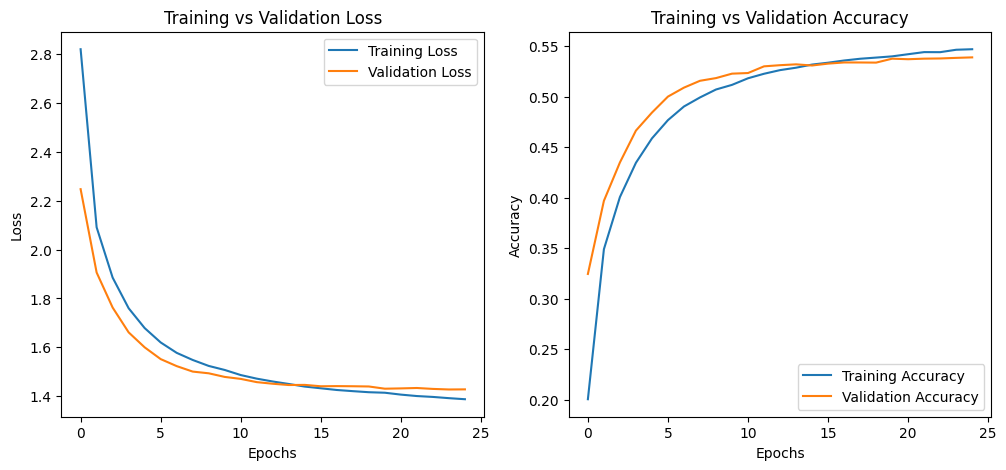

In [97]:
plot_training_metrics(history12)

In [98]:
print("Model 5 ('starting' model with the best data split) performance metrics:")
print(f"Accuracy: {metrics5['accuracy']:.2f}%")
print(f"Perplexity: {metrics5['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics5['top_n_accuracy']:.2f}%")

print("\nModel 6 (added LSTM & dense) performance metrics:")
print(f"Accuracy: {metrics6['accuracy']:.2f}%")
print(f"Perplexity: {metrics6['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics6['top_n_accuracy']:.2f}%")

print("\nModel 7 (added LSTM & dense + dropout) performance metrics:")
print(f"Accuracy: {metrics7['accuracy']:.2f}%")
print(f"Perplexity: {metrics7['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics7['top_n_accuracy']:.2f}%")

print("\nModel 8 (GRU + dropout) performance metrics:")
print(f"Accuracy: {metrics8['accuracy']:.2f}%")
print(f"Perplexity: {metrics8['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics8['top_n_accuracy']:.2f}%")

print("\nModel 9 (GRU + sentence length) performance metrics:")
print(f"Accuracy: {metrics9['accuracy']:.2f}%")
print(f"Perplexity: {metrics9['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics9['top_n_accuracy']:.2f}%")

print("\nModel 10 (GRU + sentence length + stride) performance metrics:")
print(f"Accuracy: {metrics10['accuracy']:.2f}%")
print(f"Perplexity: {metrics10['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics10['top_n_accuracy']:.2f}%")

print("\nModel 11 (GRU + sentence length + stride + reduced dropouts) performance metrics:")
print(f"Accuracy: {metrics11['accuracy']:.2f}%")
print(f"Perplexity: {metrics11['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics11['top_n_accuracy']:.2f}%")

metrics12 = evaluate_model_performance(model12, x_test_10, y_test_10, N=3)
print("\nModel 12 (optimized architecture) performance metrics:")
print(f"Accuracy: {metrics12['accuracy']:.2f}%")
print(f"Perplexity: {metrics12['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics12['top_n_accuracy']:.2f}%")

Model 5 ('starting' model with the best data split) performance metrics:
Accuracy: 46.58%
Perplexity: 5.56
Top-3 Accuracy: 71.13%

Model 6 (added LSTM & dense) performance metrics:
Accuracy: 48.76%
Perplexity: 5.11
Top-3 Accuracy: 72.91%

Model 7 (added LSTM & dense + dropout) performance metrics:
Accuracy: 49.02%
Perplexity: 4.86
Top-3 Accuracy: 73.74%

Model 8 (GRU + dropout) performance metrics:
Accuracy: 49.62%
Perplexity: 4.89
Top-3 Accuracy: 73.76%

Model 9 (GRU + sentence length) performance metrics:
Accuracy: 50.67%
Perplexity: 4.68
Top-3 Accuracy: 74.54%

Model 10 (GRU + sentence length + stride) performance metrics:
Accuracy: 51.97%
Perplexity: 4.40
Top-3 Accuracy: 76.10%

Model 11 (GRU + sentence length + stride + reduced dropouts) performance metrics:
Accuracy: 52.90%
Perplexity: 4.32
Top-3 Accuracy: 76.46%

Model 12 (optimized architecture) performance metrics:
Accuracy: 53.88%
Perplexity: 4.17
Top-3 Accuracy: 77.45%


# Thirteenth model: Bidirectional GRU

In this model I attempted to use bidirectional GRUs. The idea is to allow the model to capture dependencies in both temporal directions, since text does have this bidirectional dependency.

In [102]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional

keras.utils.set_random_seed(seed)

model13 = Sequential()
model13.add(Dense(64, activation='relu', input_shape=(sentence_length, len(chars))))
model13.add(Dropout(0.05))
model13.add(Bidirectional(GRU(128, return_sequences=True)))
model13.add(Dropout(0.05))
model13.add(Dense(64, activation='relu'))
model13.add(Dropout(0.05))
model13.add(Bidirectional(GRU(128)))
model13.add(Dropout(0.05))
model13.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model13.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model13.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 45, 64)              │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 45, 256)             │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 45, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 45, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 40)                  │          10,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 327,336 (1.25 MB)

 Trainable params: 327,336 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history13 = model13.fit(x_train_10, y_train_10,
                      batch_size = 8192,
                      epochs = 25,
                      validation_data = (x_val_10, y_val_10),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 678ms/step - accuracy: 0.1324 - loss: 3.3517 - val_accuracy: 0.2738 - val_loss: 2.5008
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 648ms/step - accuracy: 0.2945 - loss: 2.3354 - val_accuracy: 0.3811 - val_loss: 1.9591
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 712ms/step - accuracy: 0.3828 - loss: 1.9546 - val_accuracy: 0.4257 - val_loss: 1.7937
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 654ms/step - accuracy: 0.4196 - loss: 1.8158 - val_accuracy: 0.4564 - val_loss: 1.6953
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 705ms/step - accuracy: 0.4458 - loss: 1.7239 - val_accuracy: 0.4740 - val_loss: 1.6332
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 723ms/step - accuracy: 0.4641 - loss: 1.6628 - val_accuracy: 0.4917 - val_loss: 1.5799
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 644ms/step - accuracy: 0.4819 - loss: 1.6086 - val_accuracy: 0.5021 - val_loss: 1.5497
Epoch 8/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 722ms/step - accuracy: 0.4917 - loss: 1.5732 - val_accu

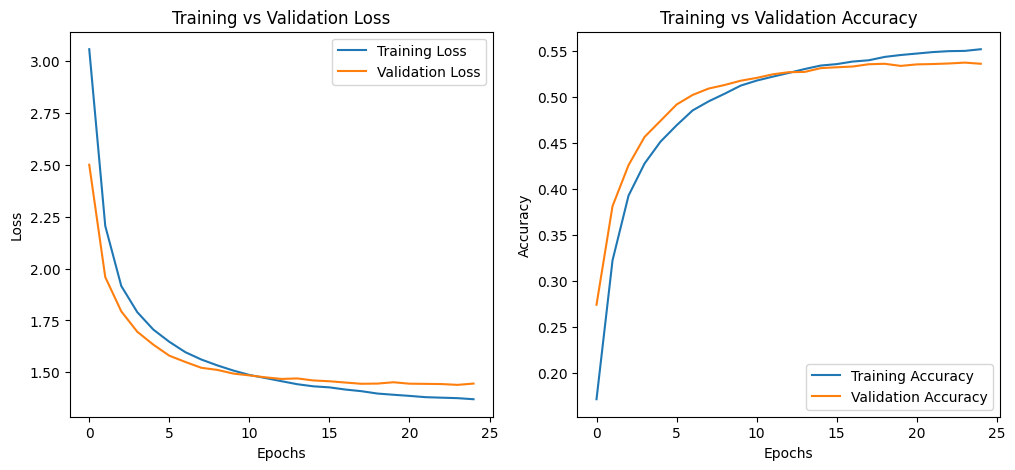

In [104]:
plot_training_metrics(history13)

In [109]:
print("Model 12 (optimized architecture) performance metrics:")
print(f"Accuracy: {metrics12['accuracy']:.2f}%")
print(f"Perplexity: {metrics12['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics12['top_n_accuracy']:.2f}%")

metrics13 = evaluate_model_performance(model13, x_test_10, y_test_10, N=3)
print("\nModel 13 (bidirectional GRU) performance metrics:")
print(f"Accuracy: {metrics13['accuracy']:.2f}%")
print(f"Perplexity: {metrics13['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics13['top_n_accuracy']:.2f}%")

Model 12 (optimized architecture) performance metrics:
Accuracy: 53.88%
Perplexity: 4.17
Top-3 Accuracy: 77.45%

Model 13 (bidirectional GRU) performance metrics:
Accuracy: 53.67%
Perplexity: 4.20
Top-3 Accuracy: 77.18%


The performance is close, but not quite as good. I will then keep the previous model as the best one.

# Fourteenth model: secondary branch

This is the result of a research, I have found that in these recurrent NNs it can be useful to have a secondary branch of dense layers that can learn additional information from the GRU output, which might not be fully captured by the GRU layers.

I also tried to put a recurrent component but it was not effective.

In [130]:
# Input layer
input_layer = Input(shape=(sentence_length, len(chars)))

# Main Sequential Path
x = Dense(64, activation='relu')(input_layer)
x = Dropout(0.05)(x)
x = GRU(128, return_sequences=True)(x)
x = Dropout(0.05)(x)
x = GRU(128)(x)
x = Dropout(0.05)(x)

# MLP Branch
mlp_branch = Dense(64, activation='relu')(x)
mlp_branch = Dropout(0.05)(mlp_branch)
mlp_branch = Dense(32, activation='relu')(mlp_branch)

# Merge main path and MLP branch
merged = concatenate([x, mlp_branch])

# Output layer
output_layer = Dense(len(chars), activation='softmax')(merged)

# Model definition
model14 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model14.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model summary
model14.summary()

Model: "functional_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 45, 40)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_58 (Dense)          │ (None, 45, 64)         │          2,624 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_62 (Dropout)      │ (None, 45, 64)         │              0 │ dense_58[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_28 (GRU)              │ (None, 45, 128)        │         74,496 │ dropout_62[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_63 (Dropout)      │ (None, 45, 128)        │              0 │ gru_28[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_29 (GRU)              │ (None, 128)            │         99,072 │ dropout_63[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_64 (Dropout)      │ (None, 128)            │              0 │ gru_29[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_59 (Dense)          │ (None, 64)             │          8,256 │ dropout_64[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_65 (Dropout)      │ (None, 64)             │              0 │ dense_59[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 32)             │          2,080 │ dropout_65[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 160)            │              0 │ dropout_64[0][0],      │
│ (Concatenate)             │                        │                │ dense_60[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_61 (Dense)          │ (None, 40)             │          6,440 │ concatenate_6[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 192,968 (753.78 KB)

 Trainable params: 192,968 (753.78 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history14 = model14.fit(x_train_10, y_train_10,
                      batch_size = 8192,
                      epochs = 25,
                      validation_data = (x_val_10, y_val_10),
                      shuffle=True,
                      callbacks=[early_stopping])

Epoch 1/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.1554 - loss: 3.1425 - val_accuracy: 0.3260 - val_loss: 2.2162
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.3423 - loss: 2.1237 - val_accuracy: 0.3994 - val_loss: 1.8727
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.4014 - loss: 1.8665 - val_accuracy: 0.4498 - val_loss: 1.7136
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.4446 - loss: 1.7269 - val_accuracy: 0.4756 - val_loss: 1.6275
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.4709 - loss: 1.6418 - val_accuracy: 0.4997 - val_loss: 1.5519
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - accuracy: 0.4913 - loss: 1.5747 - val_accuracy: 0.5093 - val_loss: 1.5180
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.5025 - loss: 1.5330 - val_accuracy: 0.5174 - val_loss: 1.4909
Epoch 8/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - accuracy: 0.5126 - loss: 1.5008 - val_accu

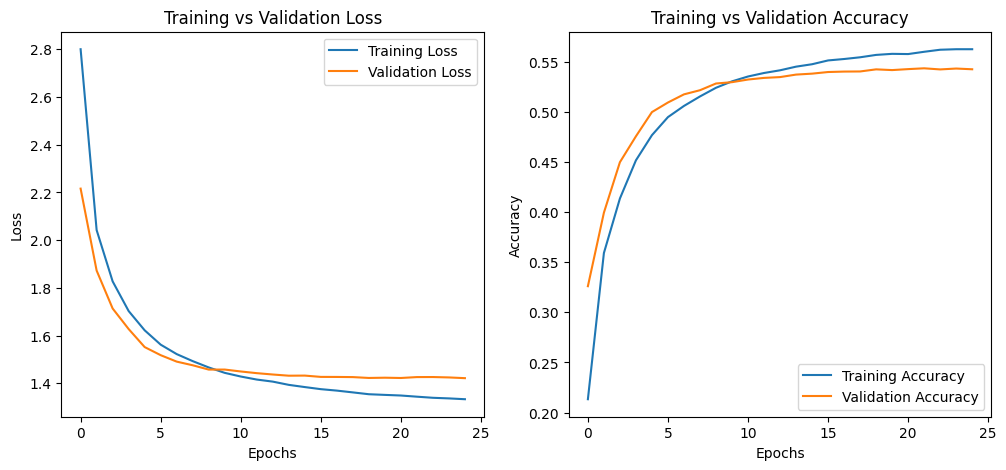

In [132]:
plot_training_metrics(history14)

In [133]:
print("Model 12 (optimized architecture) performance metrics:")
print(f"Accuracy: {metrics12['accuracy']:.2f}%")
print(f"Perplexity: {metrics12['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics12['top_n_accuracy']:.2f}%")

metrics14 = evaluate_model_performance(model14, x_test_10, y_test_10, N=3)
print("\nModel 14 (secondary path) performance metrics:")
print(f"Accuracy: {metrics14['accuracy']:.2f}%")
print(f"Perplexity: {metrics14['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics14['top_n_accuracy']:.2f}%")

Model 12 (optimized architecture) performance metrics:
Accuracy: 53.88%
Perplexity: 4.17
Top-3 Accuracy: 77.45%

Model 14 (secondary path) performance metrics:
Accuracy: 54.30%
Perplexity: 4.14
Top-3 Accuracy: 77.46%


# Extrernal test

Lastly, I have used an external test set to assess the generalization capability of the model. I used another work from Dante: 'Le rime petrose' (suggested by a friend of mine that studies classic literature). The idea was to try to test the model on something that can be somewhat close to the dataset used for training. However, the 'Divina Commedia' is very unique, so even this test set will probably have a much worse accuracy.

I had to of course perform some data processing to make sure that the characters of the test set are the same as the training set.

In [171]:
import io

file_path = '/content/drive/My Drive/rime_petrose.txt'

# Open and read the file
with io.open(file_path, mode='r', encoding='utf-8') as f:
    text2 = f.read().lower()

print('Text length:', len(text2))
print('\nFirst 1000 characters:\n')
print(text2[:1000])

# Define the accented characters and replace them with the letter followed by a backtick
accented_chars = {
    'è': 'e`', 'é': 'e`', 'ê': 'e`', 'ë': 'e`',
    'à': 'a`', 'á': 'a`', 'ä': 'a`', 'â': 'a`',
    'ì': 'i`', 'í': 'i`', 'ï': 'i`', 'î': 'i`',
    'ò': 'o`', 'ó': 'o`', 'ö': 'o`', 'ô': 'o`',
    'ù': 'u`', 'ú': 'u`', 'ü': 'u`', 'û': 'u`',
    'ç': 'c`', 'ñ': 'n`'
}

# Replace accented characters in text2
for accent, replacement in accented_chars.items():
    text2 = text2.replace(accent, replacement)

# Replace » with > and « with <
text2 = text2.replace('»', '>').replace('«', '<')

# Replace curly apostrophe ’ with straight apostrophe '
text2 = text2.replace('’', "'")

# Show the modified text (optional, print first 1000 characters for example)
print('\nModified first 1000 characters:\n')
print(text2[:1000])


Text length: 9945

First 1000 characters:

io son venuto al punto de la rota  
che l’orizzonte, quando il sol si corca,  
ci partorisce il geminato cielo,  
e la stella d’amor ci sta remota  
per lo raggio lucente che la ’nforca  
sì di traverso che le si fa velo;  
e quel pianeta che conforta il gelo  
si mostra tutto a noi per lo grand’arco  
nel qual ciascun di sette fa poca ombra:  
e però non disgombra  
un sol penser d’amore, ond’io son carco,  
la mente mia, ch’è più dura che petra  
in tener forte imagine di petra.  

levasi de la rena d’etiopia  
lo vento peregrin che l’aere turba,  
per la spera del sol ch’ora la scalda;  
e passa il mare, onde conduce copia  
di nebbia tal, che, s’altro non la sturba,  
questo emisperio chiude tutto e salda;  
e poi si solve, e cade in bianca falda  
di fredda neve ed in noiosa pioggia,  
onde l’aere s’attrista tutto e piagne:  
e amor, che sue ragne  
ritira in alto pel vento che poggia,  
non m’abbandona, sì è bella donna  
questa crudel c

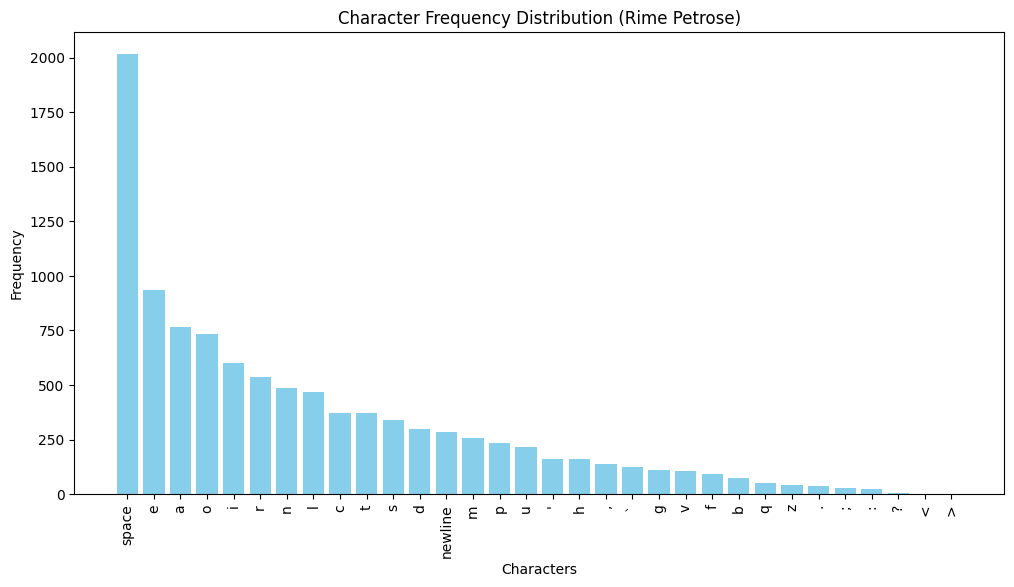

Top 10 most frequent characters in Rime Petrose:
'space' appears 2016 times (20.02%)
'e' appears 937 times (9.31%)
'a' appears 767 times (7.62%)
'o' appears 733 times (7.28%)
'i' appears 602 times (5.98%)
'r' appears 537 times (5.33%)
'n' appears 487 times (4.84%)
'l' appears 466 times (4.63%)
'c' appears 372 times (3.69%)
't' appears 371 times (3.68%)

Number of unique characters in Rime Petrose: 32


In [172]:
# Count the frequency of each character in the text
char_counts2 = Counter(text2)

# Add labels for special characters
char_labels = {" ": "space", "\n": "newline"}

# Update character keys with labels where applicable
labeled_char_counts2 = {char_labels.get(char, char): count for char, count in char_counts2.items()}

# Recalculate total characters with labeled counts
total_characters2 = sum(labeled_char_counts2.values())

# Separate the characters and their counts for plotting
characters2 = list(labeled_char_counts2.keys())
frequencies2 = list(labeled_char_counts2.values())

# Sort by frequency for better visualization
sorted_indices2 = sorted(range(len(frequencies2)), key=lambda k: frequencies2[k], reverse=True)
sorted_characters2 = [characters2[i] for i in sorted_indices2]
sorted_frequencies2 = [frequencies2[i] for i in sorted_indices2]

# Plot the character distribution
plt.figure(figsize=(12, 6))
plt.bar(sorted_characters2, sorted_frequencies2, color='skyblue')
plt.title('Character Frequency Distribution (Rime Petrose)')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Display the top 10 most frequent characters
print("Top 10 most frequent characters in Rime Petrose:")
for char, freq in zip(sorted_characters2[:10], sorted_frequencies2[:10]):
    percentage = (freq / total_characters2) * 100
    print(f"'{char}' appears {freq} times ({percentage:.2f}%)")

# Print the number of unique characters in text2
unique_characters2 = len(labeled_char_counts2)
print(f"\nNumber of unique characters in Rime Petrose: {unique_characters2}")


In [173]:
# Count the frequency of each character in both texts (text1 and text2)
char_counts1 = Counter(text)
char_counts2 = Counter(text2)

# Add labels for special characters
char_labels = {" ": "space", "\n": "newline"}

# Update character keys with labels where applicable
labeled_char_counts1 = {char_labels.get(char, char): count for char, count in char_counts1.items()}
labeled_char_counts2 = {char_labels.get(char, char): count for char, count in char_counts2.items()}

# Get sets of unique characters in both texts
unique_chars1 = set(labeled_char_counts1.keys())
unique_chars2 = set(labeled_char_counts2.keys())

# Find characters in text1 but not in text2, and vice versa
chars_in_text1_not_text2 = unique_chars1 - unique_chars2
chars_in_text2_not_text1 = unique_chars2 - unique_chars1

# Print the results
print("Characters in text1 but not in text2:")
print(chars_in_text1_not_text2)

print("\nCharacters in text2 but not in text1:")
print(chars_in_text2_not_text1)


Characters in text1 but not in text2:
{'j', '-', '"', '!', 'y', ')', 'x', '('}

Characters in text2 but not in text1:
set()


In [174]:
# Generate sequences for the test set
sentences_test2, next_chars_test2 = generate_sequences(text2, sentence_length, 1)

# One-hot encode the test set sequences
x_extranal_test, y_extranal_test = one_hot_encode_sequences(sentences_test2, next_chars_test2, char_indices, sentence_length)

# Display the shapes of the test set
print('x_extranal_test shape: ', x_extranal_test.shape)  # number of sequences, sequence length, number of unique characters
print('y_extranal_test shape: ', y_extranal_test.shape)  # number of sequences, number of unique characters

x_extranal_test shape:  (10023, 45, 40)
y_extranal_test shape:  (10023, 40)


In [176]:
print("Model 14 (secondary path) performance metrics:")
print(f"Accuracy: {metrics14['accuracy']:.2f}%")
print(f"Perplexity: {metrics14['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics14['top_n_accuracy']:.2f}%")

metrics_test = evaluate_model_performance(model14, x_extranal_test, y_extranal_test, N=3)
print("\nExtranal test set performance metrics:")
print(f"Accuracy: {metrics_test['accuracy']:.2f}%")
print(f"Perplexity: {metrics_test['perplexity']:.2f}")
print(f"Top-3 Accuracy: {metrics_test['top_n_accuracy']:.2f}%")

Model 14 (secondary path) performance metrics:
Accuracy: 54.30%
Perplexity: 4.14
Top-3 Accuracy: 77.46%

Extranal test set performance metrics:
Accuracy: 38.35%
Perplexity: 13.12
Top-3 Accuracy: 62.97%


Of course the performance on external test set is much worse, and there is no way to improve the generalization of the model enough to account for a very different style, language, words... all the considerations I made during the first models where I attempted different data splits are very important here, the unpredictability and uniqueness of the training text play an important role.